In [1]:
!pip install shap

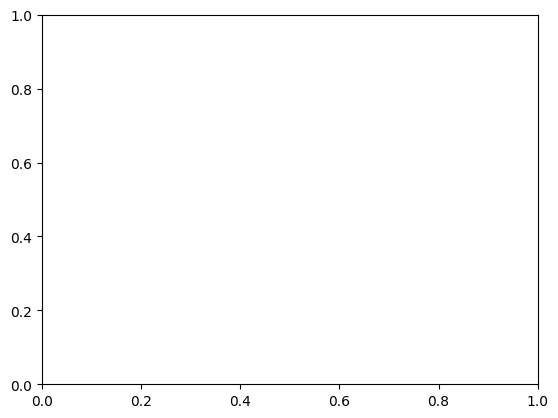

In [2]:
#IMPORTING THE LIBRARIES
import numpy as np
import shap
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import os
import scipy as sp
import warnings
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings("ignore")
%matplotlib inline
ax = plt.gca()

########## Img dpi ############
plt.rcParams['figure.dpi'] = 200

In [3]:
def plot_roc_multiclass(y_train, y_test, y_proba, target_names, tittle):
  from sklearn.preprocessing import LabelBinarizer
  label_binarizer = LabelBinarizer().fit(y_train)
  y_onehot_test = label_binarizer.transform(y_test)
  y_onehot_test.shape  # (n_samples, n_classes)

  ##clases:
  n_classes = len(np.unique(y_test))
  #names
  target_names = target_names

  from sklearn.metrics import roc_curve, auc

  # store the fpr, tpr, and roc_auc for all averaging strategies
  fpr, tpr, roc_auc = dict(), dict(), dict()
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_proba.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  #print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  fpr_grid = np.linspace(0.0, 1.0, 1000)

  # Interpolate all ROC curves at these points
  mean_tpr = np.zeros_like(fpr_grid)

  for i in range(n_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

  # Average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

  from itertools import cycle

  fig, ax = plt.subplots(figsize=(6, 6))

#  plt.plot(
#      fpr["micro"],
#      tpr["micro"],
#      label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
#      color="deeppink",
#      linestyle=":",
#      linewidth=4,
#  )#

#  plt.plot(
#      fpr["macro"],
#      tpr["macro"],
#      label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
#      color="navy",
#      linestyle=":",
#      linewidth=4,
#  )

  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for class_id, color in zip(range(n_classes), colors):
      RocCurveDisplay.from_predictions(
          y_onehot_test[:, class_id],
          y_proba[:, class_id],
          name=f"ROC curve for {target_names[class_id]}",
          color=color,
          ax=ax,
      )

  plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(tittle)
  plt.legend()
  plt.show()


In [4]:
# LOADING THE DATASET
my_sheet = 'S1-CD' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = 'FRX-sondeo-lagunaCopia de 53572_results-MJ.xlsx' # change it to the name of your excel file
df = read_excel(file_name, sheet_name = my_sheet)

In [5]:
df

Unnamed: 0  cm muestreo-marga  cluster      Na      Mg      Al  \
0     TEN20-S1-CD-30                 30        1  0.0004  0.0128  0.1695   
1     TEN20-S1-CD-60                 60        1  0.0000  0.0125  0.1859   
2    TEN20-S1-CD-100                100        1  0.0017  0.0116  0.1687   
3    TEN20-S1-CD-150                150        2  0.0009  0.0121  0.1953   
4    TEN20-S1-CD-205                205        1  0.0008  0.0107  0.1889   
5    TEN20-S1-CD-250                250        2  0.0000  0.0120  0.1907   
6    TEN20-S1-CD-265                265        3  0.0010  0.0127  0.2100   
7    TEN20-S1-CD-340                340        1  0.0002  0.0124  0.1814   
8    TEN20-S1-CD-380                380        1  0.0009  0.0118  0.1760   
9    TEN20-S1-CD-410                410        1  0.0004  0.0118  0.1812   
10   TEN20-S1-CD-470                470        1  0.0008  0.0113  0.1857   
11   TEN20-S1-CD-520                520        2  0.0000  0.0105  0.1965   
12   TEN20-S1-CD-550                550        2  0.0004  0.0118  0.1922   
13   TEN20-S1-CD-650                650        2  0.0007  0.0119  0.1859   
14   TEN20-S1-CD-740                740        2  0.0035  0.0116  0.1982   
15   TEN20-S1-CD-790                790        2  0.0017  0.0119  0.2019   
16   TEN20-S1-CD-820                820        2  0.0031  0.0119  0.1906   
17   TEN20-S1-CD-860                860        2  0.0030  0.0118  0.2050   
18   TEN20-S1-CD-890                890        2  0.0013  0.0118  0.1958   
19   TEN20-S1-CD-940                940        3  0.0021  0.0112  0.2170   
20  TEN20-S1-CD-1010               1010        3  0.0021  0.0101  0.2182   
21  TEN20-S1-CD-1055               1055        3  0.0018  0.0106  0.2051   
22  TEN20-S1-CD-1120               1120        3  0.0011  0.0103  0.2345   
23  TEN20-S1-CD-1180               1180        3  0.0019  0.0101  0.2173   
24  TEN20-S1-CD-1280               1280        2  0.0023  0.0112  0.1905   
25  TEN20-S1-CD-1325               1325        3  0.0026  0.0108  0.2086   
26  TEN20-S1-CD-1395               1395        2  0.0023  0.0107  0.2074   
27  TEN20-S1-CD-1425               1425        3  0.0028  0.0114  0.2052   
28  TEN20-S1-CD-1480               1480        2  0.0004  0.0123  0.2002   
29  TEN20-S1-CD-1540               1540        2  0.0003  0.0094  0.2151   
30  TEN20-S1-CD-1590               1590        2  0.0008  0.0118  0.1946   
31  TEN20-S1-CD-1660               1660        2  0.0000  0.0123  0.1898   
32  TEN20-S1-CD-1710               1710        2  0.0004  0.0124  0.1992   
33  TEN20-S1-CD-1730               1730        3  0.0004  0.0125  0.2070   
34  TEN20-S1-CD-1800               1800        2  0.0004  0.0138  0.1847   
35  TEN20-S1-CD-1840               1840        2  0.0019  0.0160  0.1903   
36  TEN20-S1-CD-1880               1880        3  0.0007  0.0125  0.2112   
37  TEN20-S1-CD-1900               1900        2  0.0065  0.0098  0.1980   
38  TEN20-S1-CD-1975               1975        2  0.0029  0.0120  0.2019   
39  TEN20-S1-CD-2020               2020        3  0.0056  0.0238  0.2122   
40  TEN20-S1-CD-2060               2060        3  0.0054  0.0145  0.2222   
41  TEN20-S1-CD-2085               2085        3  0.0033  0.0136  0.2365   
42  TEN20-S1-CD-2110               2110        3  0.0029  0.0155  0.2226   

        Si       P       S      Cl  ...      Rb      Sr       Y      Zr  \
0   0.2714  0.0053  0.0008  0.0011  ...  0.0001  0.0007  0.0000  0.0018   
1   0.2528  0.0056  0.0007  0.0010  ...  0.0001  0.0006  0.0000  0.0020   
2   0.2625  0.0052  0.0007  0.0013  ...  0.0002  0.0007  0.0001  0.0021   
3   0.2658  0.0054  0.0009  0.0009  ...  0.0001  0.0008  0.0001  0.0022   
4   0.2604  0.0075  0.0005  0.0012  ...  0.0006  0.0001  0.0021  0.0004   
5   0.2829  0.0052  0.0006  0.0012  ...  0.0002  0.0006  0.0001  0.0023   
6   0.3164  0.0050  0.0007  0.0013  ...  0.0002  0.0007  0.0001  0.0026   
7   0.2669  0.0039  0.0006  0.0012  ...  0.0002  0.0007  0.0000  

In [6]:
df.drop(['Unnamed: 0', 'cm muestreo-marga' ], axis = 'columns', inplace=True)
#drop the minor elementes
df.drop(['Na', 'S','Cl', 'Sc','V','Cr', 'Ni','Cu', 'Zn','Ga', 'Rb',
         'Sr', 'Y','Zr', 'Nb','Rh', 'Hf','Ta', 'Au','Bi'], axis = 'columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cluster  43 non-null     int64  
 1   Mg       43 non-null     float64
 2   Al       43 non-null     float64
 3   Si       43 non-null     float64
 4   P        43 non-null     float64
 5   K        43 non-null     float64
 6   Ca       43 non-null     float64
 7   Ti       43 non-null     float64
 8   Mn       43 non-null     float64
 9   Fe       43 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 3.5 KB


TRAINING AND TESTING DATA

In [7]:
#filling the NaNs
df = df.fillna(df.mean())

#dataset
x = df.drop(columns='cluster')

# Getting Predicting Value
y = df['cluster']

In [8]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
data=pd.DataFrame(minmax.fit_transform(df.drop(columns = 'cluster')),columns=df.drop(columns = 'cluster').columns)
data.head()

Mg        Al        Si         P        K        Ca        Ti  \
0  0.236111  0.011799  0.186935  0.285714  0.15625  0.170172  0.878505   
1  0.215278  0.253687  0.000000  0.339286  0.11875  0.063098  0.862928   
2  0.152778  0.000000  0.097487  0.267857  0.33125  0.045889  0.788162   
3  0.187500  0.392330  0.130653  0.303571  0.21250  0.051625  0.794393   
4  0.090278  0.297935  0.076382  0.678571  0.13750  0.072658  0.492212   

         Mn        Fe  
0  0.470588  0.834502  
1  0.272059  0.918654  
2  0.588235  0.932679  
3  0.154412  0.775596  
4  0.367647  0.908836

In [9]:
#train_test_splitting of the dataset

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [10]:
x_test

Mg      Al      Si       P       K      Ca      Ti      Mn      Fe
30  0.0118  0.1946  0.2626  0.0049  0.0116  0.0063  0.0818  0.0059  0.4112
36  0.0125  0.2112  0.3120  0.0044  0.0174  0.0084  0.0646  0.0115  0.3474
27  0.0114  0.2052  0.3128  0.0044  0.0196  0.0078  0.0689  0.0074  0.3497
4   0.0107  0.1889  0.2604  0.0075  0.0104  0.0099  0.0708  0.0070  0.4252
10  0.0113  0.1857  0.2610  0.0057  0.0135  0.0062  0.0692  0.0031  0.4347
25  0.0108  0.2086  0.3523  0.0044  0.0242  0.0073  0.0581  0.0065  0.3149
28  0.0123  0.2002  0.2758  0.0049  0.0129  0.0084  0.0752  0.0067  0.3943
11  0.0105  0.1965  0.2928  0.0054  0.0125  0.0077  0.0664  0.0036  0.3959
37  0.0098  0.1980  0.2641  0.0088  0.0082  0.0273  0.0864  0.0035  0.3789
31  0.0123  0.1898  0.2715  0.0053  0.0144  0.0069  0.0783  0.0062  0.4068
29  0.0094  0.2151  0.2851  0.0048  0.0120  0.0069  0.0706  0.0060  0.3817

In [11]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

32
11
32
11


MODELS

1. SVC

In [12]:
from sklearn.svm import SVC

svc = SVC(probability=True)
svc.fit(x_train, y_train)

SVC(probability=True)

In [13]:
y_pred=svc.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",svc.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.55      1.00      0.71         6
           3       0.00      0.00      0.00         3

    accuracy                           0.55        11
   macro avg       0.18      0.33      0.24        11
weighted avg       0.30      0.55      0.39        11

Confusion Matrix:
 [[0 2 0]
 [0 6 0]
 [0 3 0]]
Training Score:
 46.875
Mean Squared Error:
 0.45454545454545453
R2 score is:
 -0.0185185185185186


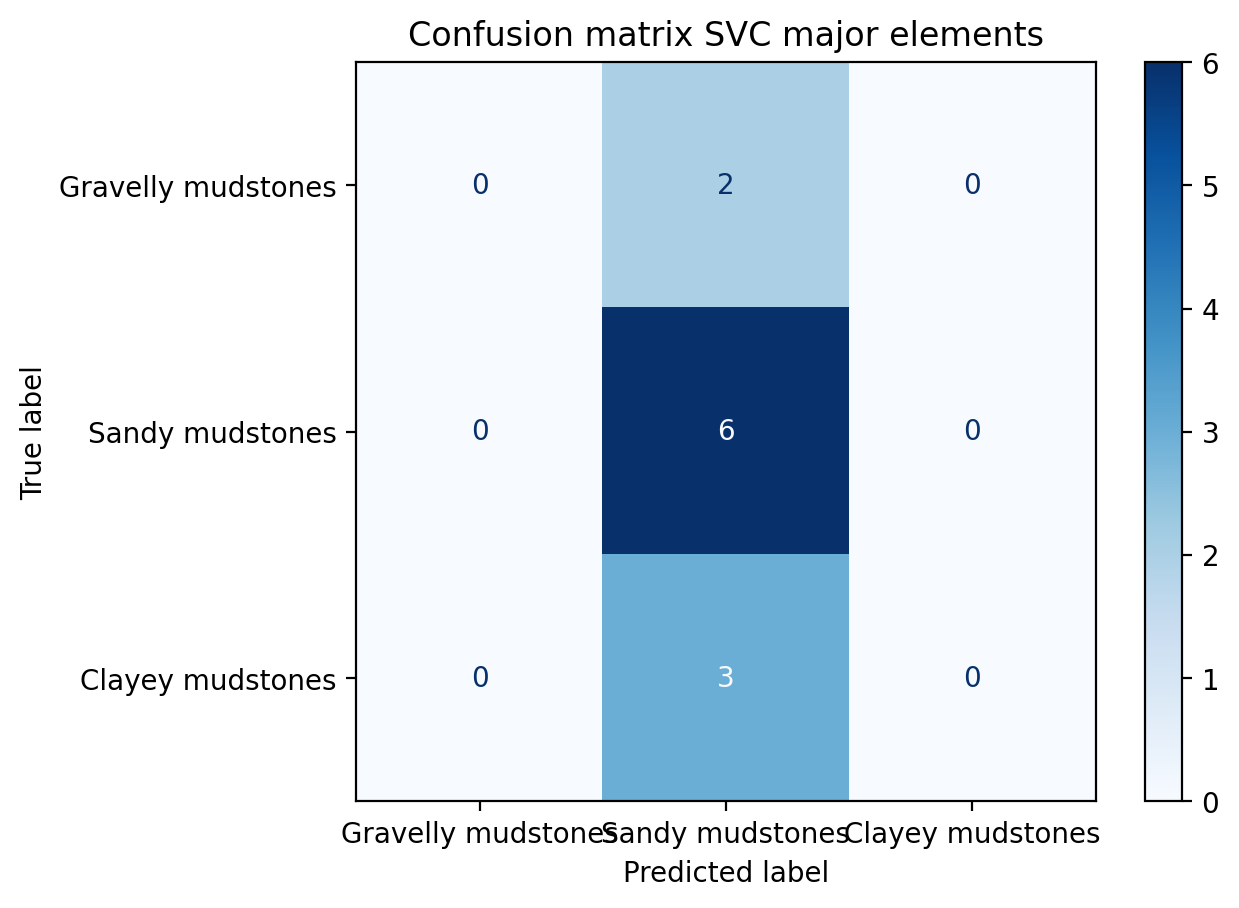

In [14]:
title_options = [
    ("Confusion matrix SVC major elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        svc,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

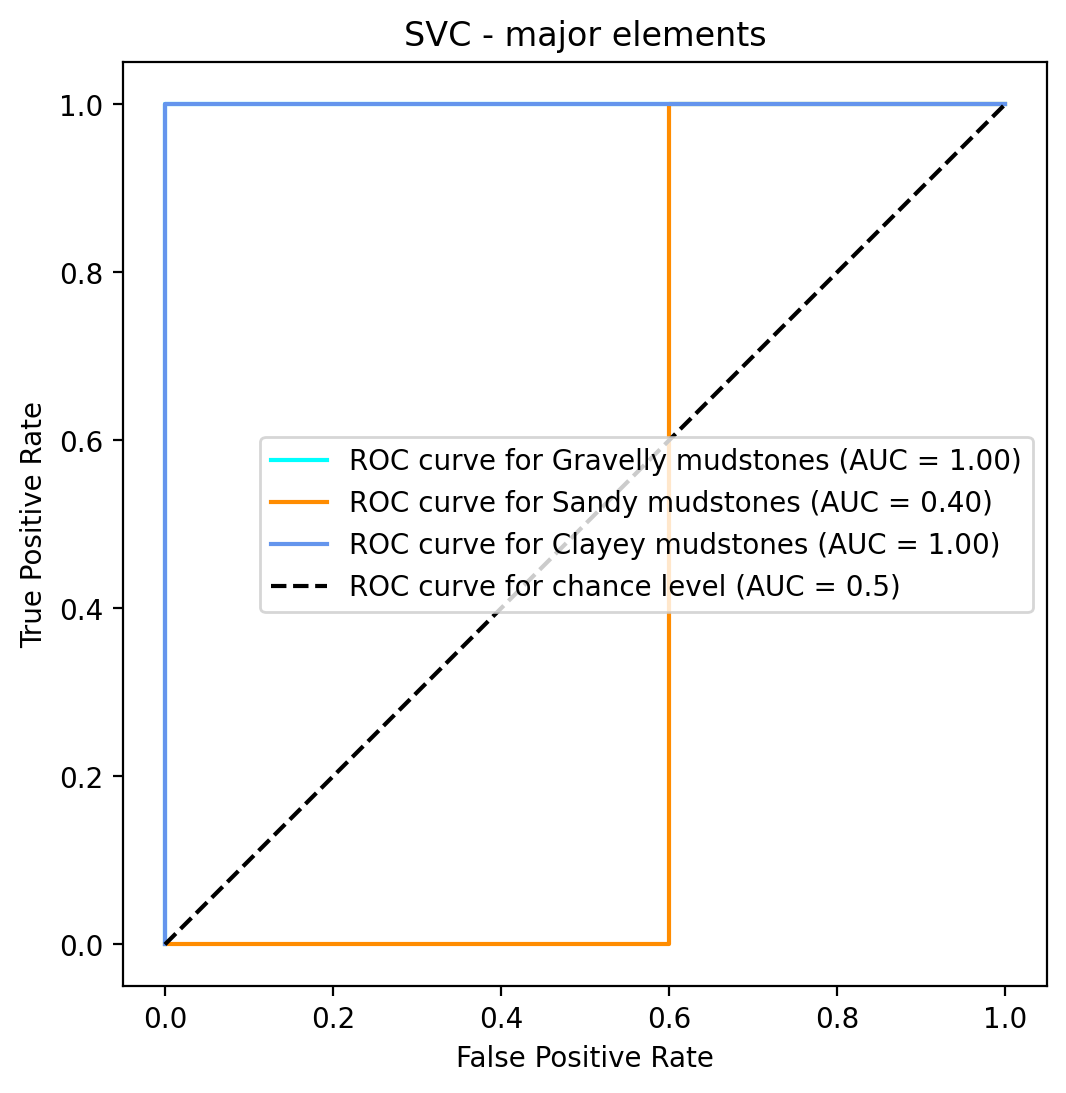

In [15]:
svc_roc = plot_roc_multiclass(y_train, y_test, svc.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "SVC - major elements")
svc_roc

In [16]:
print(accuracy_score(y_test,y_pred)*100)

54.54545454545454


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
from pprint import pprint

# Define hyperparameter grid for SVC
param_grid_svc = {
    'C': [0.1, 1, 5, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Print grid
pprint(param_grid_svc)

# Define model
svc = SVC(probability=True)  # probability=True if you want to use SHAP later

# Define GridSearchCV
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc,
                               cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV (X_train and y_train assumed defined)
#grid_search_svc.fit(x_train, y_train)

# Best parameters found
#print("Best parameters found:", grid_search_svc.best_params_)


{'C': [0.1, 1, 5, 10],
 'gamma': [0.1, 0.01, 0.001],
 'kernel': ['linear', 'rbf', 'poly']}


2. Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)

GaussianNB()

In [19]:
y_pred=gnb.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",gnb.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       0.50      0.50      0.50         2
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         3

    accuracy                           0.82        11
   macro avg       0.78      0.78      0.78        11
weighted avg       0.82      0.82      0.82        11

Confusion Matrix:
 [[1 1 0]
 [1 5 0]
 [0 0 3]]
Training Score:
 90.625
Mean Squared Error:
 0.18181818181818182
R2 score is:
 0.5925925925925926


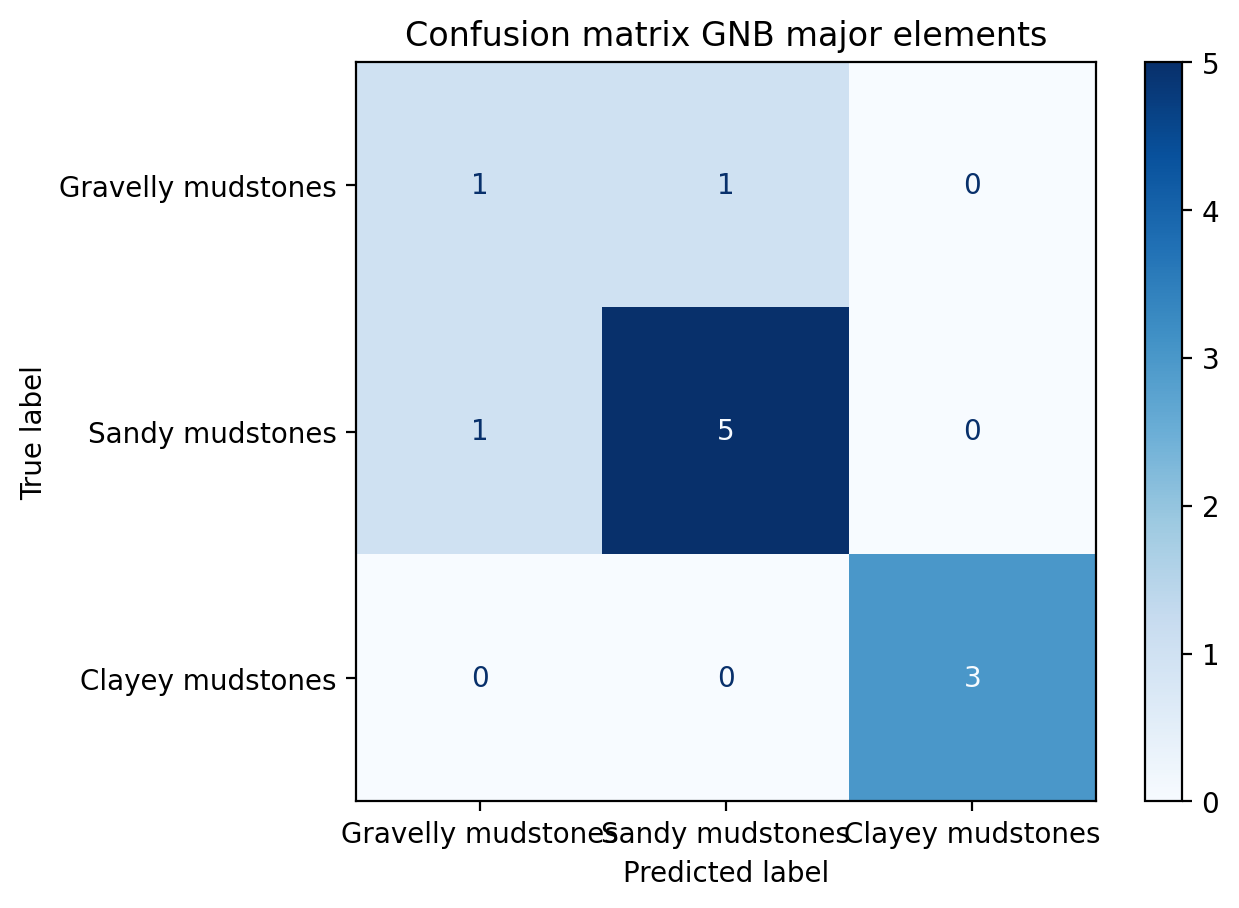

In [20]:
title_options = [
    ("Confusion matrix GNB major elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        gnb,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

In [21]:
#gnb_disp = RocCurveDisplay.from_estimator(gnb, x_test, y_test, ax=ax,alpha=0.8)

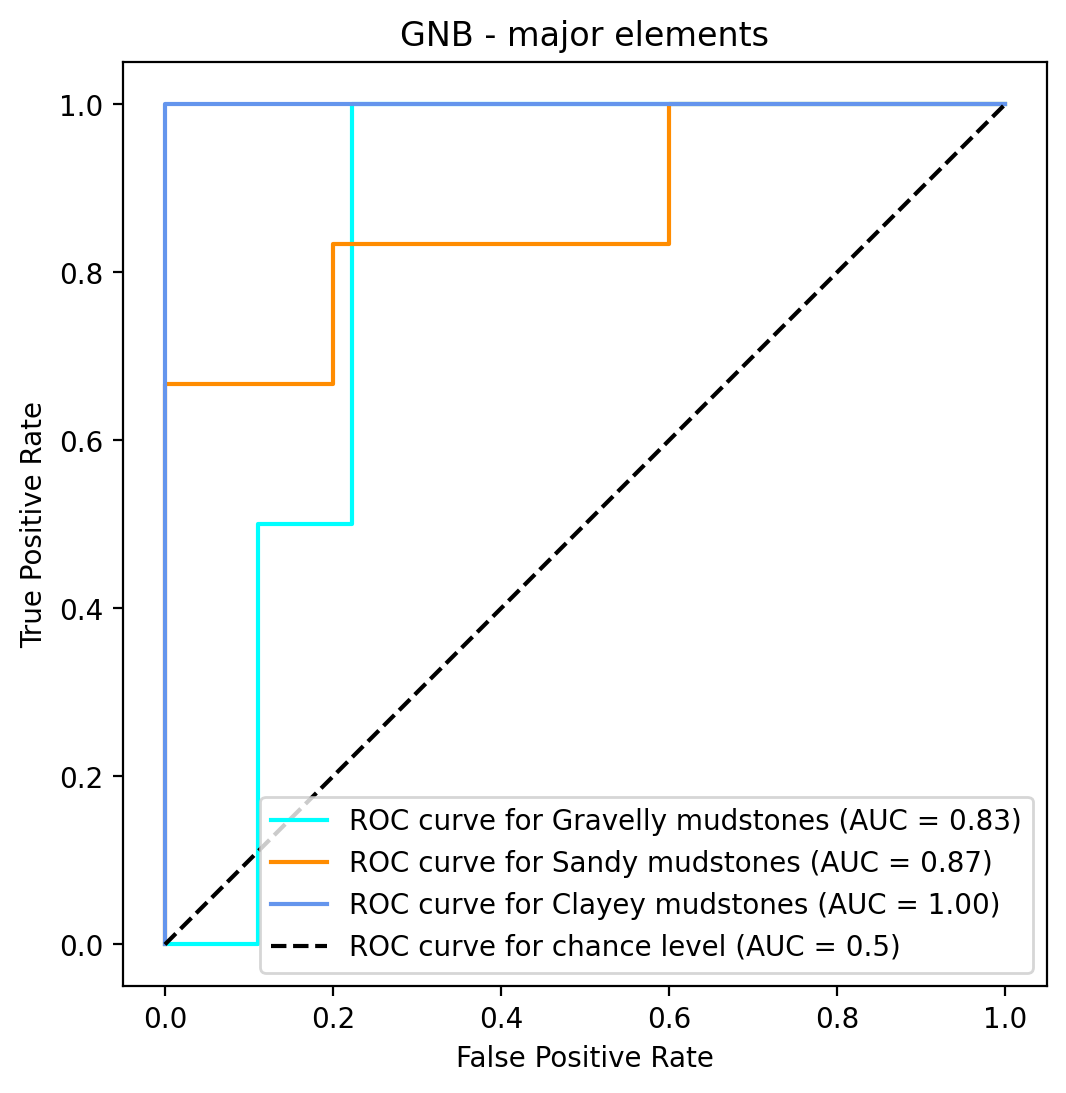

In [22]:
gnb_roc = plot_roc_multiclass(y_train, y_test, gnb.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "GNB - major elements")
gnb_roc

In [23]:
print("Accuracy Score:\n",gnb.score(x_train,y_train)*100)

Accuracy Score:
 90.625


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import numpy as np
from pprint import pprint

# Define hyperparameter grid for GaussianNB
param_grid_gnb = {
    'var_smoothing': np.logspace(0, -9, num=10)
}

# Print grid
pprint(param_grid_gnb)

# Define model
gnb = GaussianNB()

# Define GridSearchCV
grid_search_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid_gnb,
                               cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV (X_train and y_train assumed defined)
#grid_search_gnb.fit(x_train, y_train)

# Best parameters found
#print("Best parameters found:", grid_search_gnb.best_params_)

{'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])}


3 RandomForestClassifier

In [27]:
# Update (June 2025): In scikit-learn version >= 1.1, 'auto' is no longer a valid option for the 'max_features' parameter in RandomForestClassifier.
# In older versions, 'auto' was equivalent to 'sqrt' for classification tasks.
# To ensure compatibility with current versions and maintain the intended behavior, we explicitly set max_features='sqrt'.
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=1800, min_samples_split= 2,  min_samples_leaf= 1, max_features= 'sqrt',
 max_depth= 20, bootstrap= False, random_state = 42)
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1800,
                       random_state=42)

In [28]:
y_pred=rfc.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",rfc.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Confusion Matrix:
 [[2 0 0]
 [0 6 0]
 [0 0 3]]
Training Score:
 100.0
Mean Squared Error:
 0.0
R2 score is:
 1.0


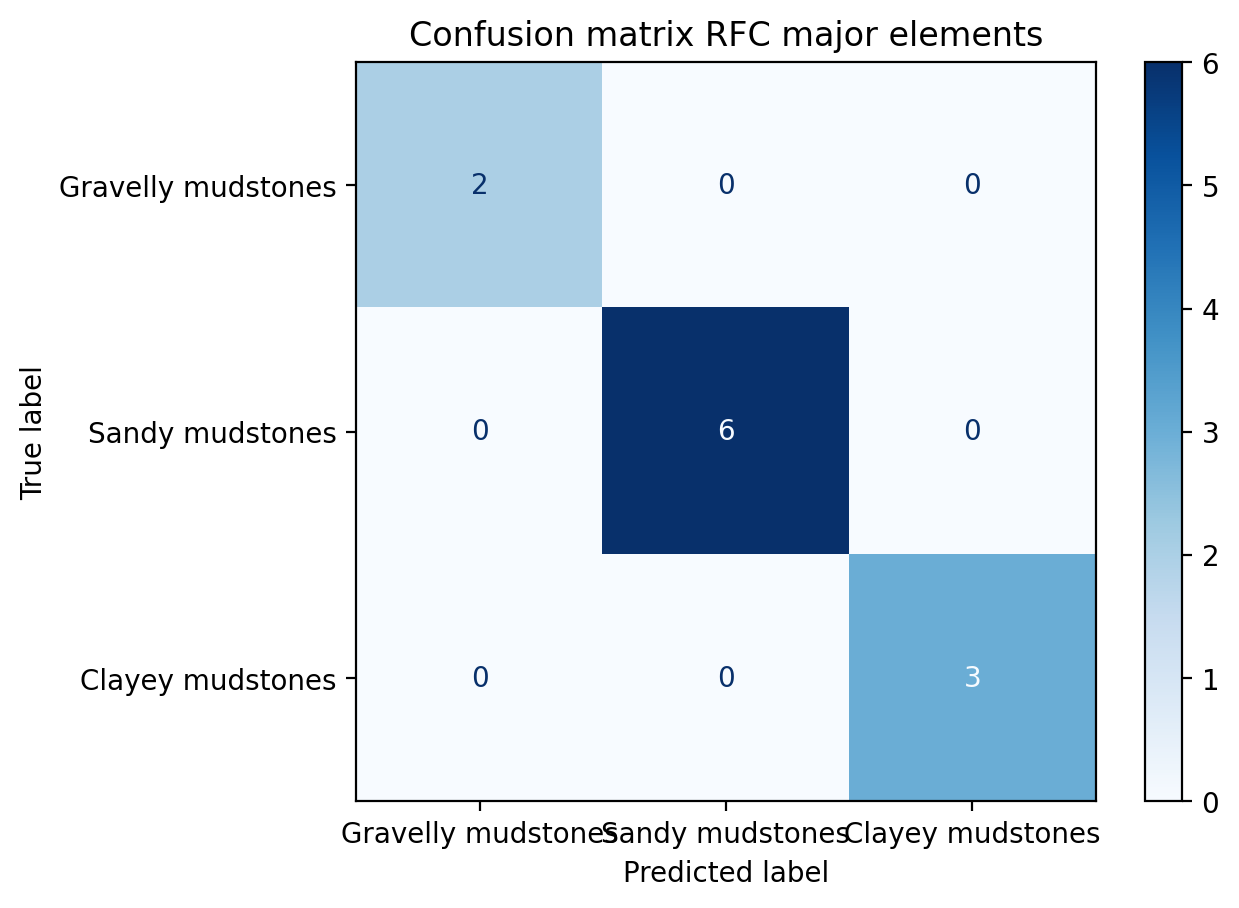

In [126]:
title_options = [
    ("Confusion matrix RFC major elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        rfc,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

In [30]:
# Fits the explainer
explainer = shap.Explainer(rfc.predict, x_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

ExactExplainer explainer: 12it [00:14,  2.88s/it]


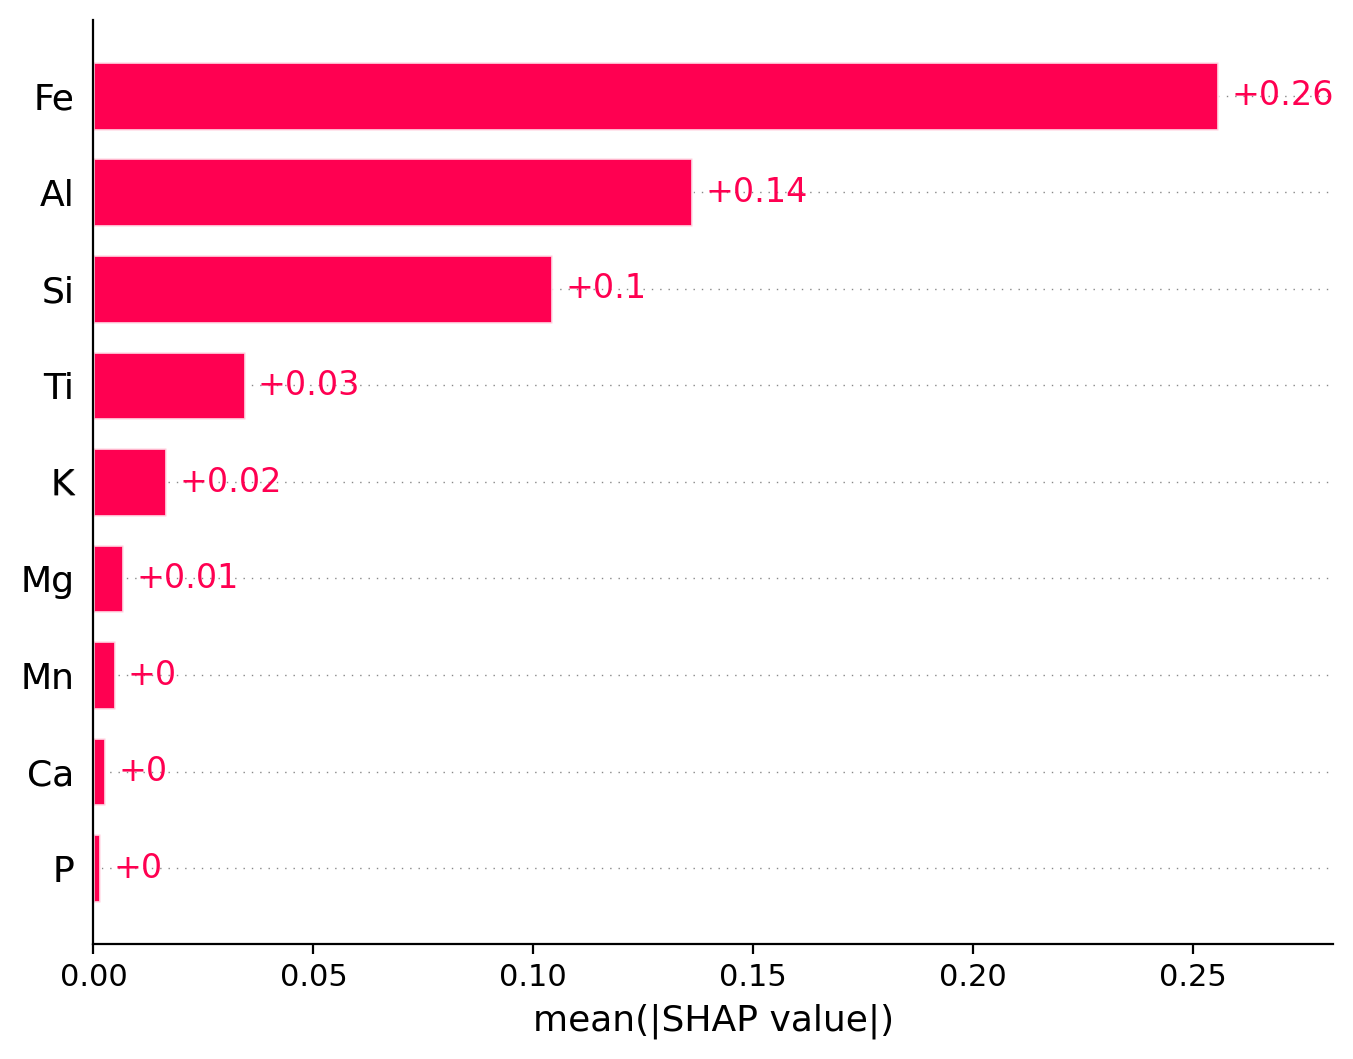

In [31]:
shap.plots.bar(shap_values)

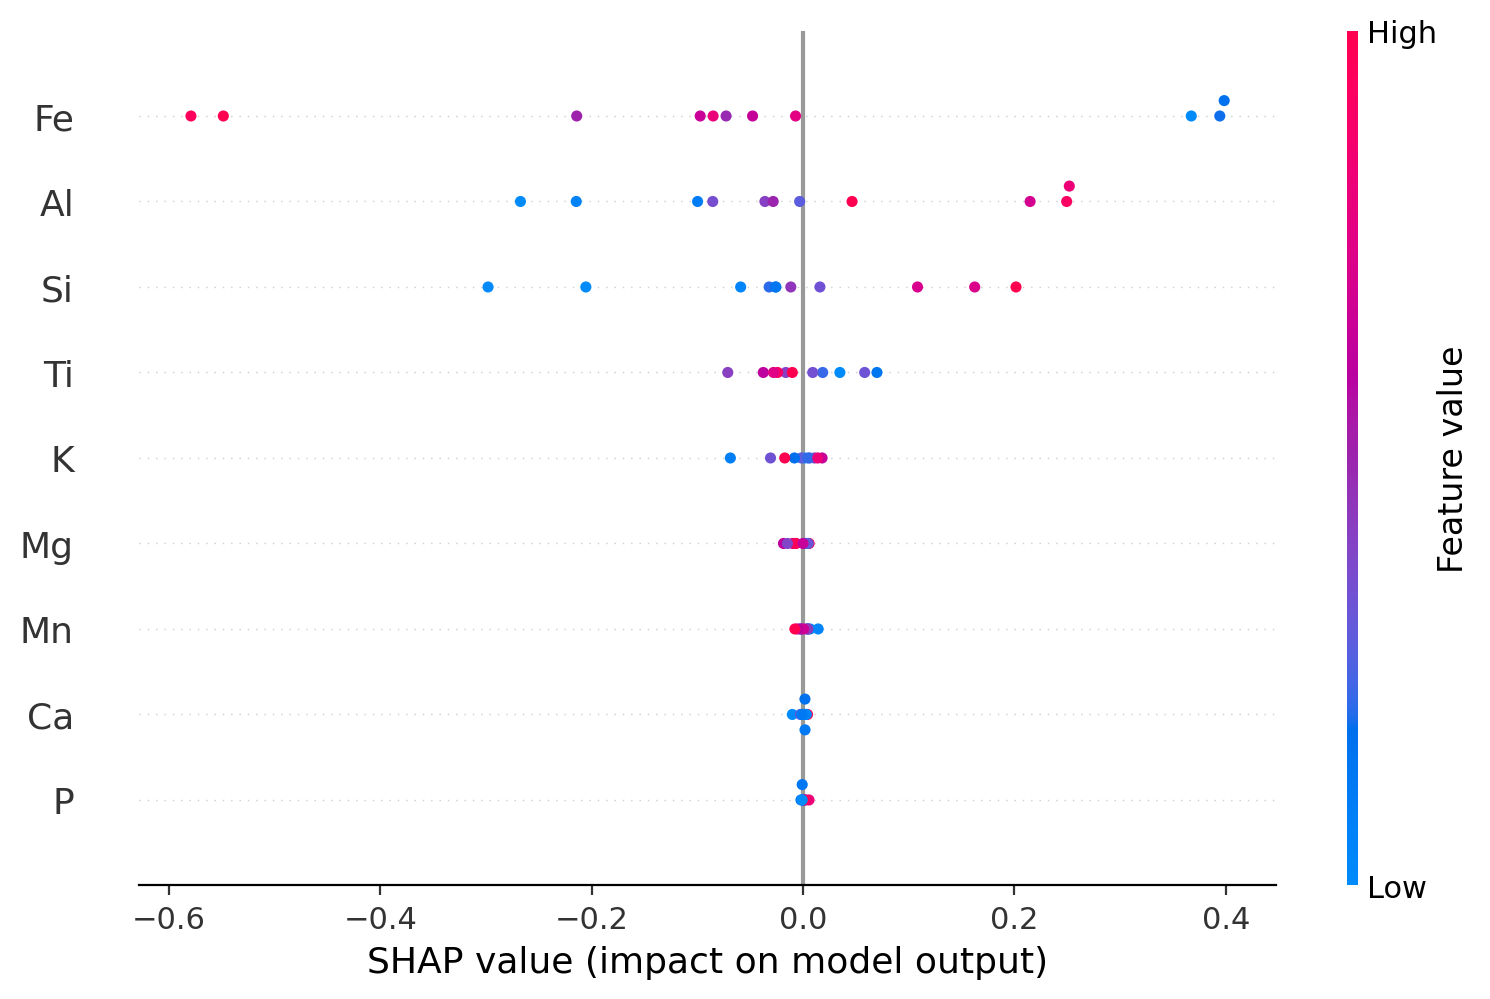

In [32]:
shap.summary_plot(shap_values)

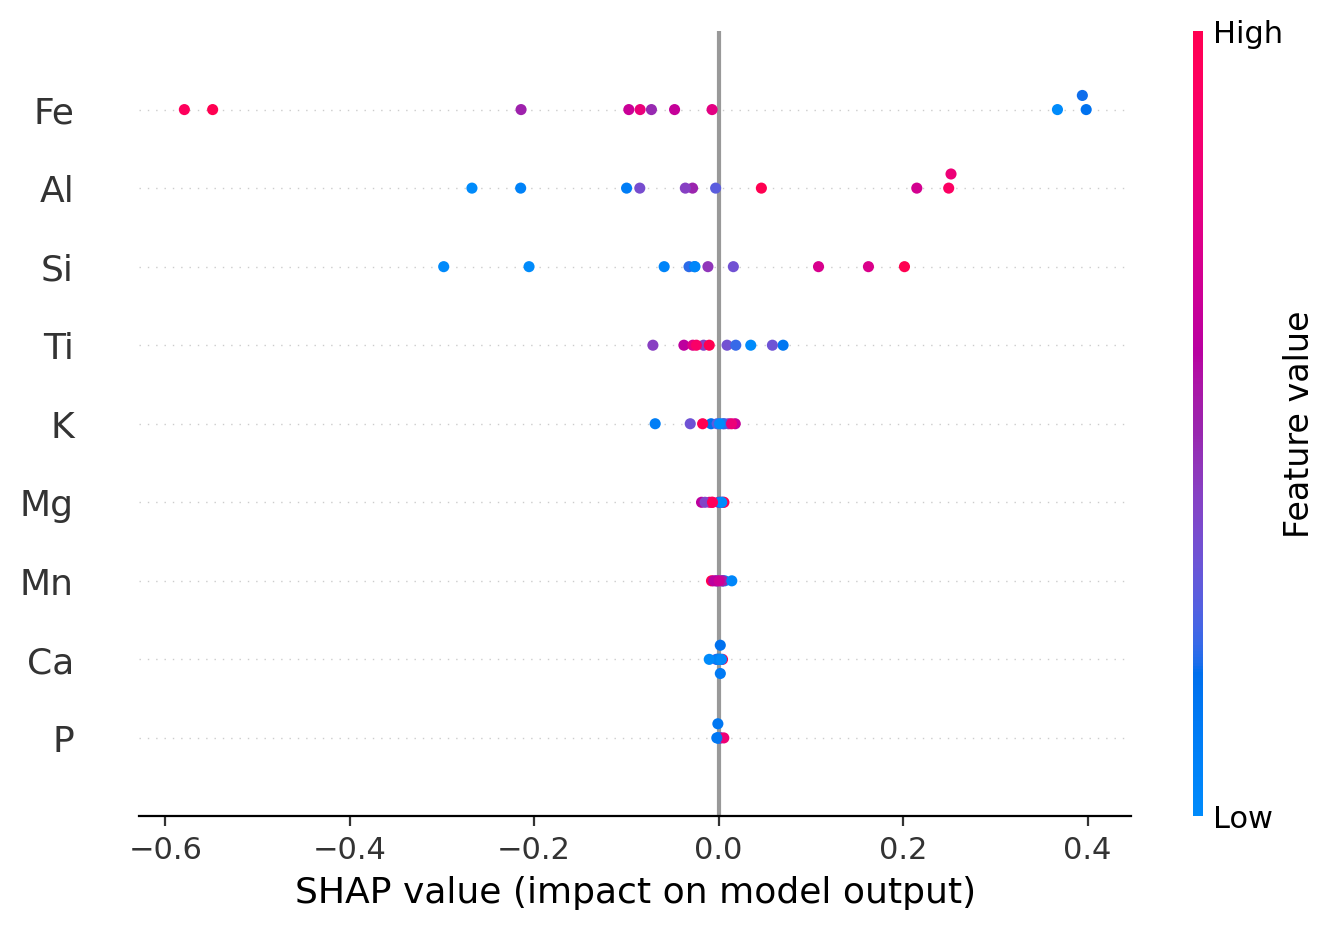

In [33]:
# or
shap.plots.beeswarm(shap_values)

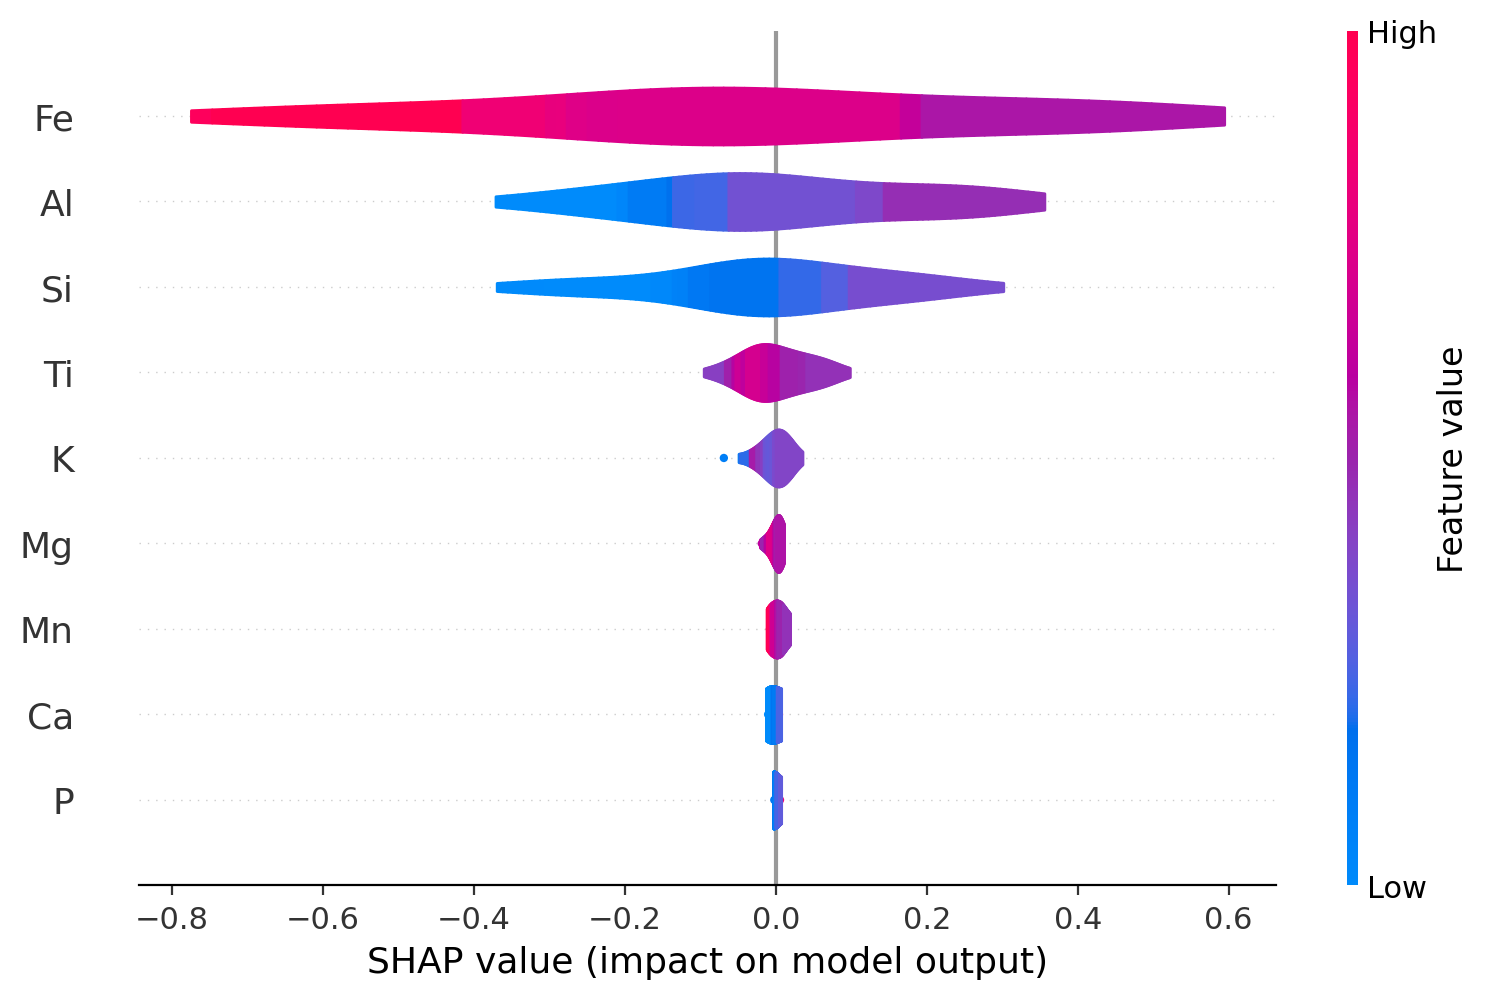

In [34]:
shap.summary_plot(shap_values, plot_type='violin')

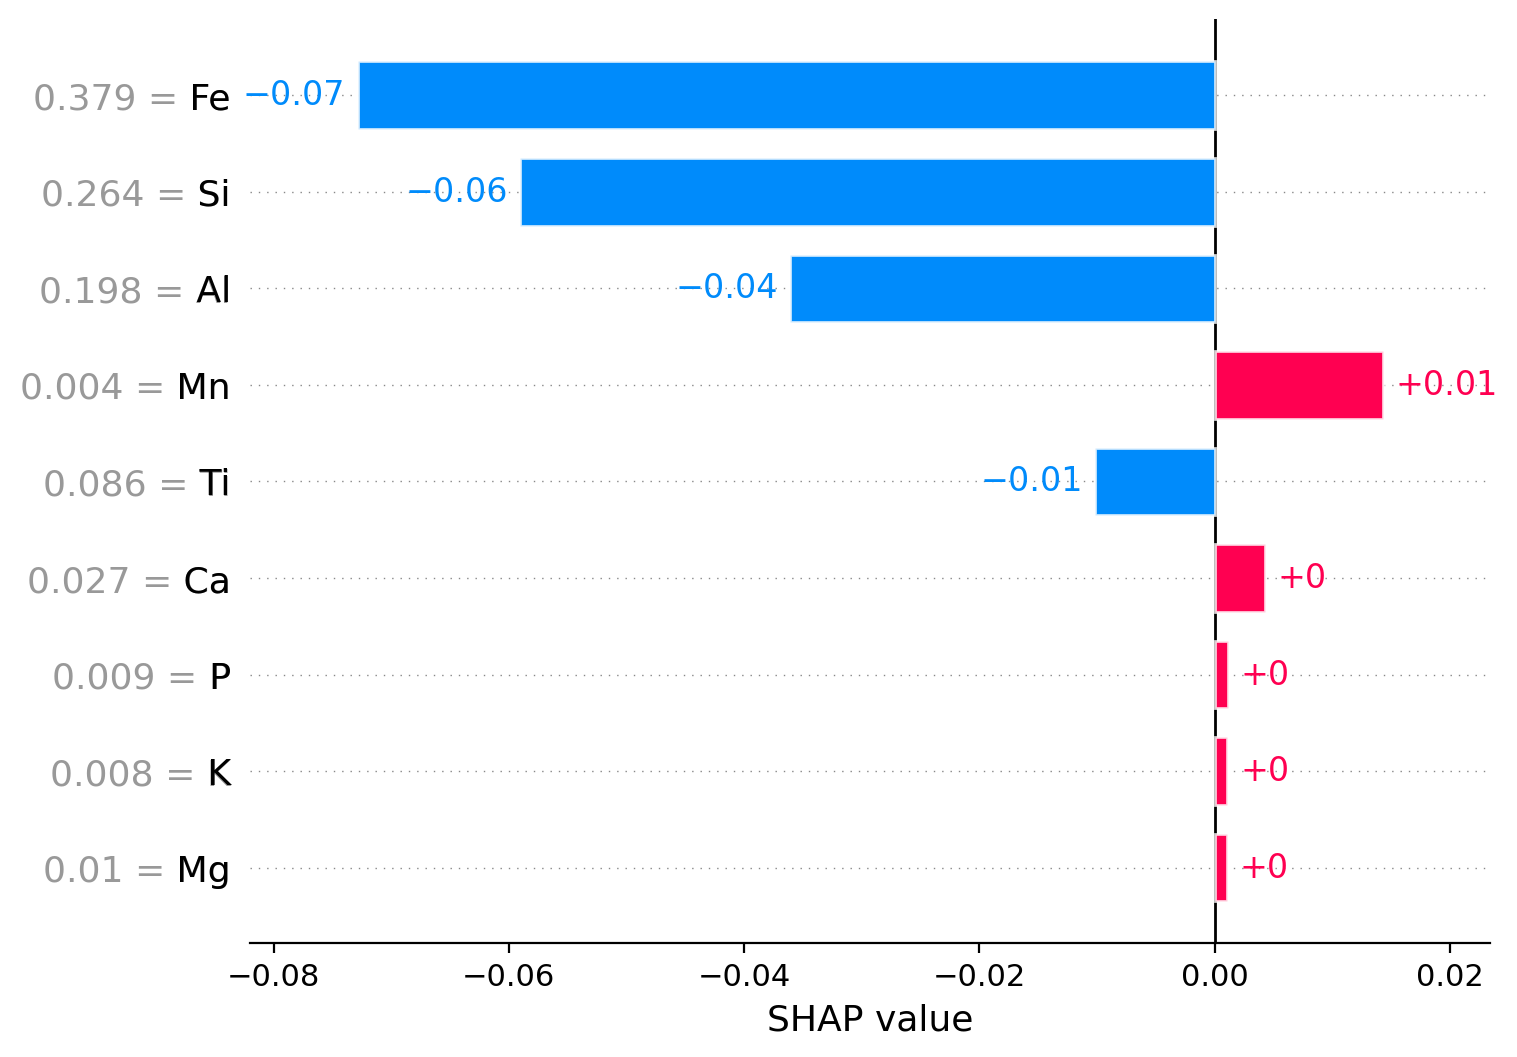

In [35]:
#Local bar plot
shap.plots.bar(shap_values[8])

In [39]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rfc)
    shap_values_Model = explainerModel.shap_values(x)
    p = shap.force_plot(explainerModel.expected_value[j], shap_values_Model[:,:,j], x)
    return(p)

In [40]:
shap.initjs()
shap_plot(0)

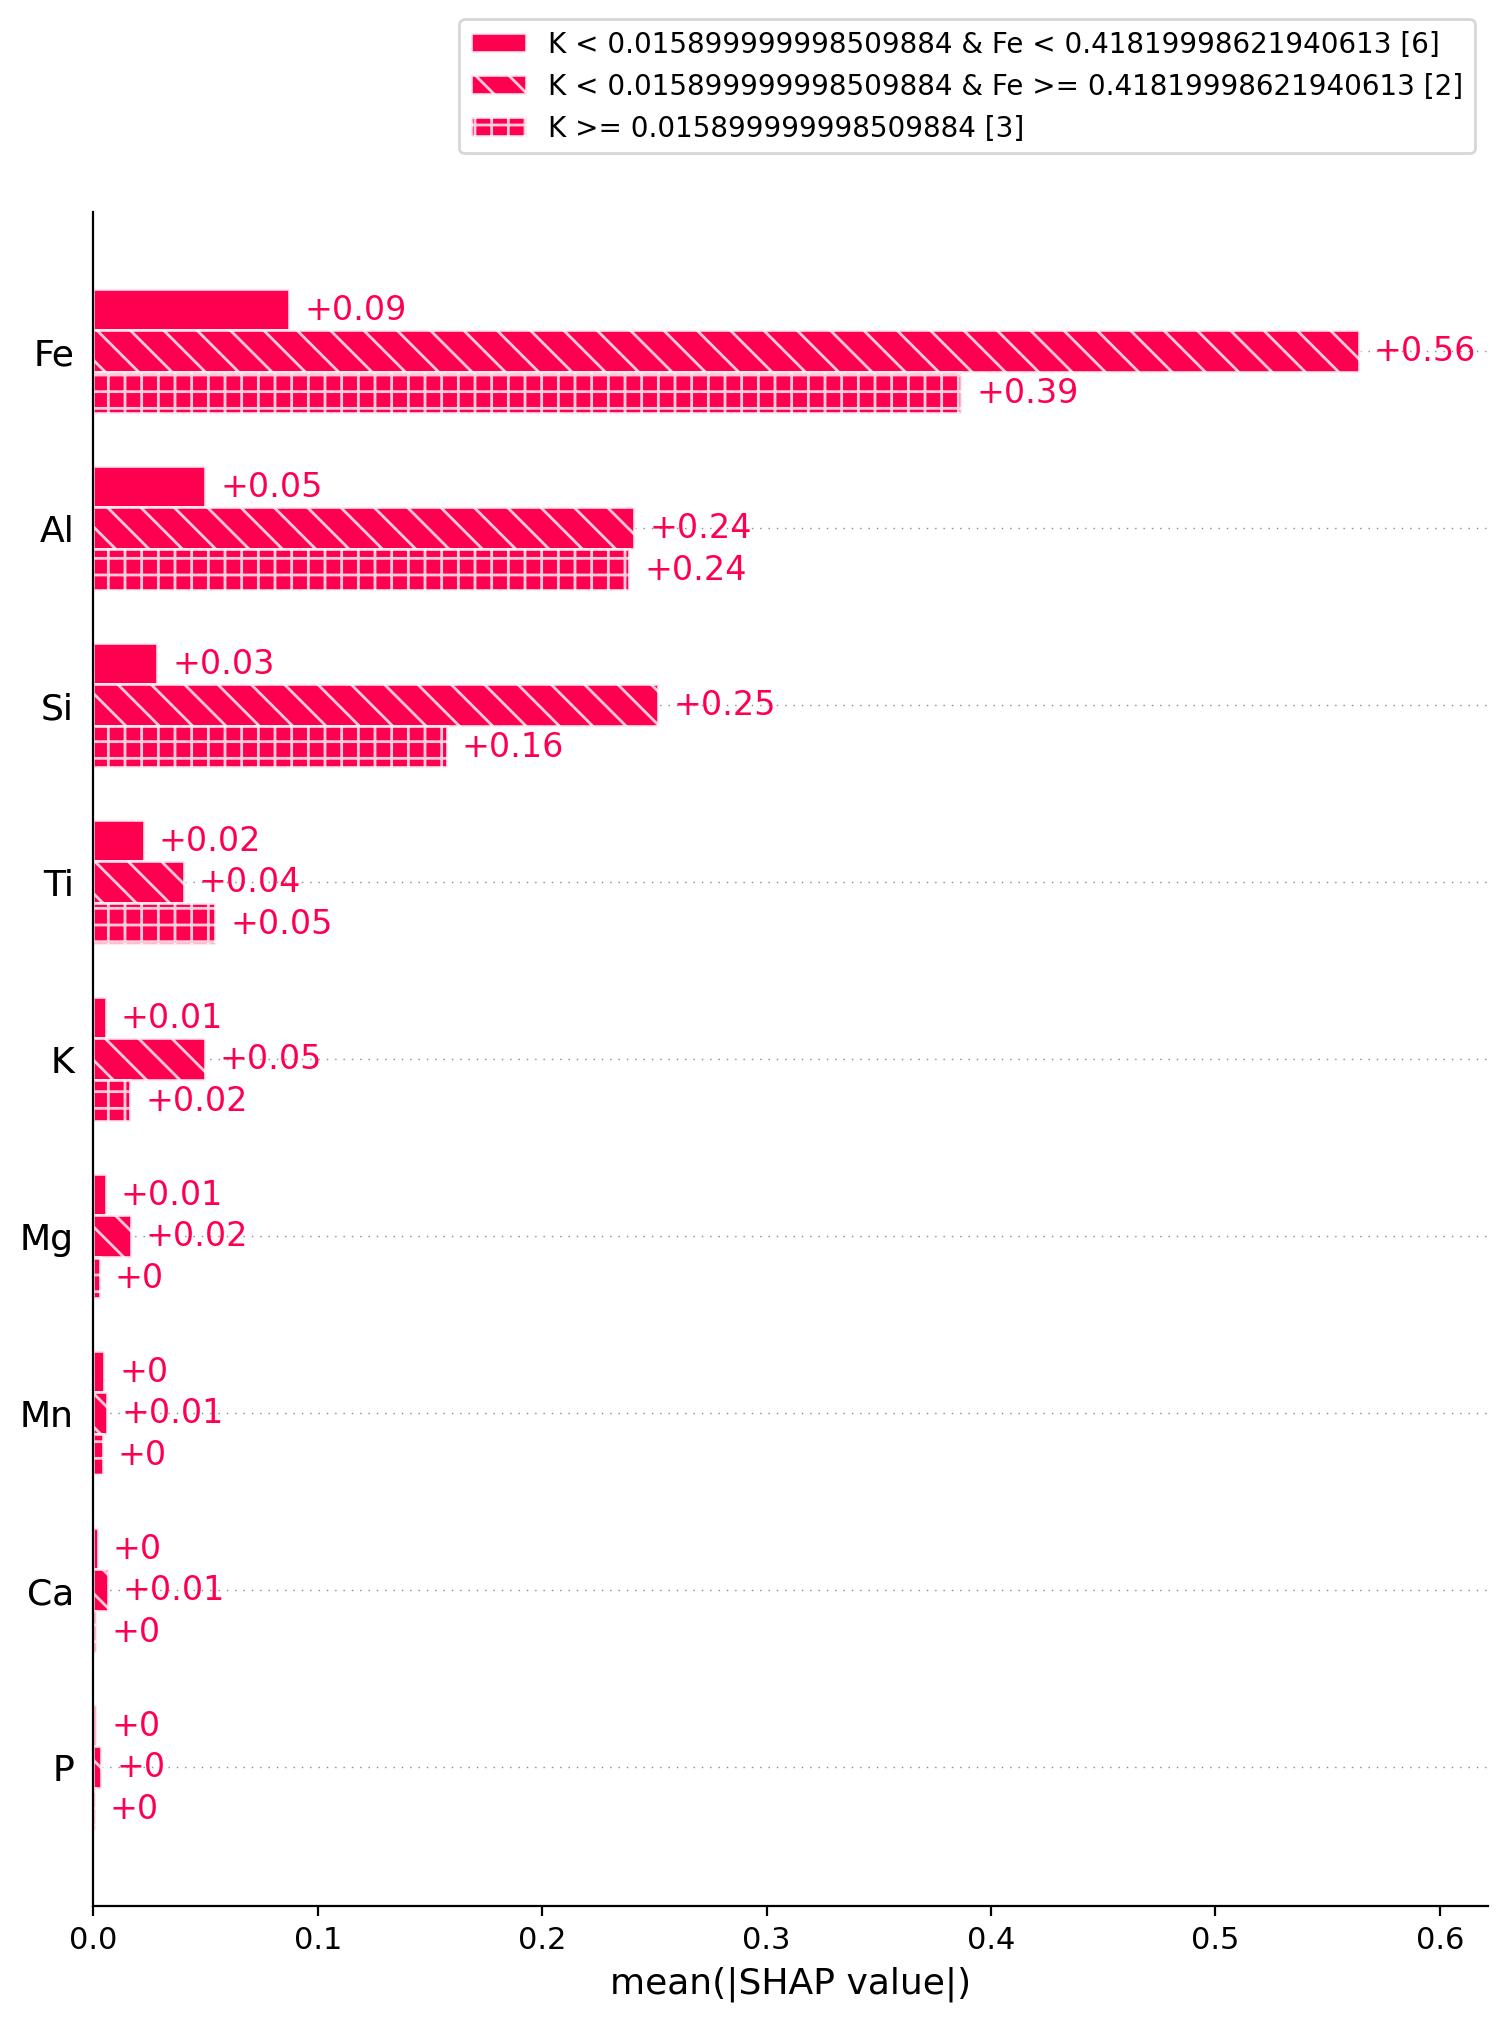

In [41]:
#shap.plots.bar(shap_values.cohorts(3).abs.mean(0))
shap.plots.bar(shap_values.cohorts(3).abs.mean(0), show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(11)
fig.set_figwidth(9)
#plt.rcParams['font.size'] = '12'
ax = plt.gca() #gca means "get current axes"
leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()

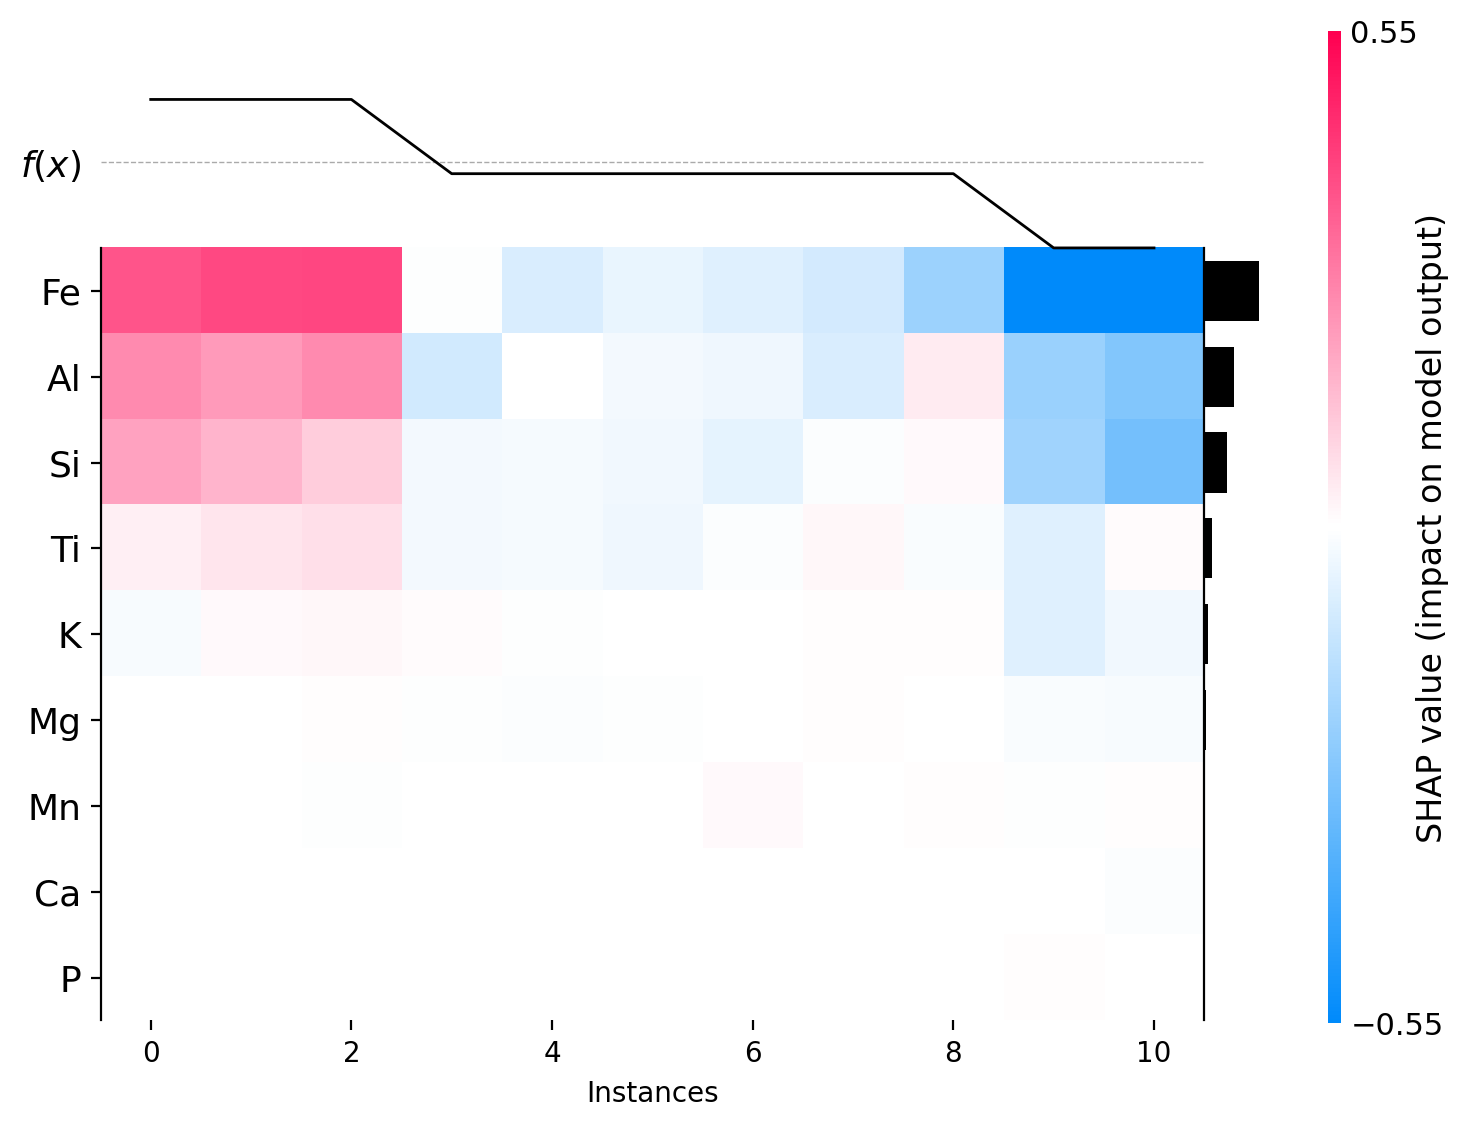

<Axes: xlabel='Instances'>

In [42]:
shap.plots.heatmap(shap_values[0:])

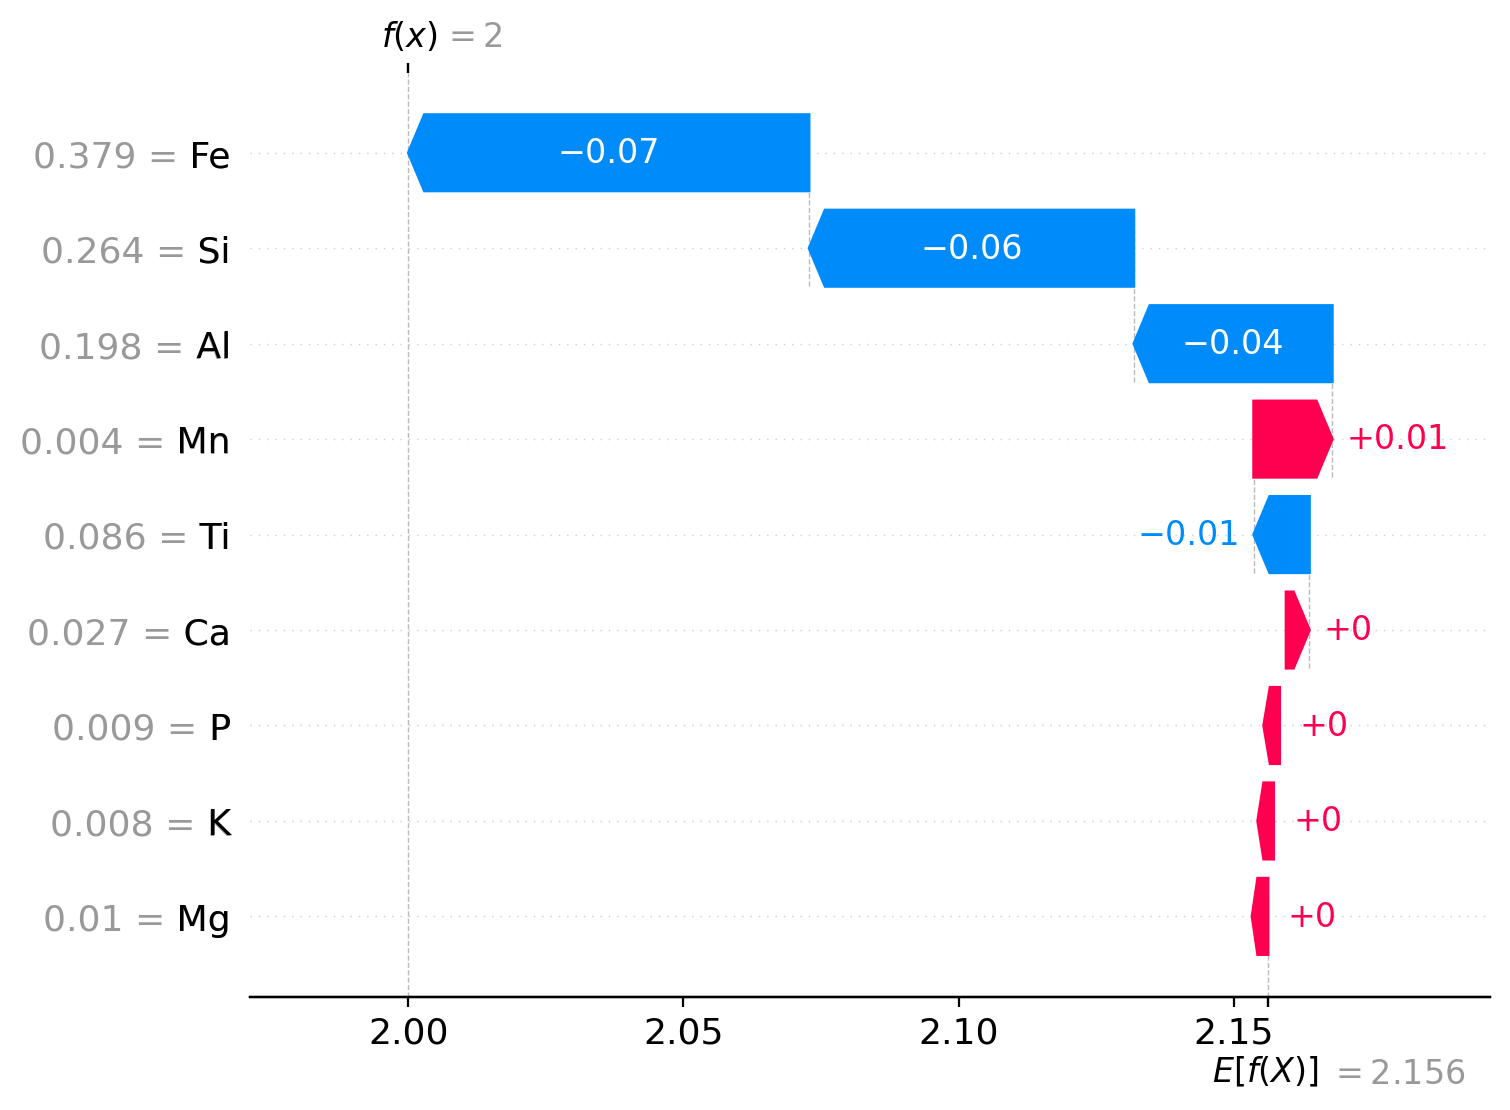

In [43]:
#Waterfall plot
shap.plots.waterfall(shap_values[8])
#The waterfall plot has the same information, represented in a different manner.
#Here we can see how the sum of all the SHAP values equals the difference between
#the prediction f(x) and the expected value E[f(x)].

In [44]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rfc)
multi_shap_values = explainer.shap_values(x)

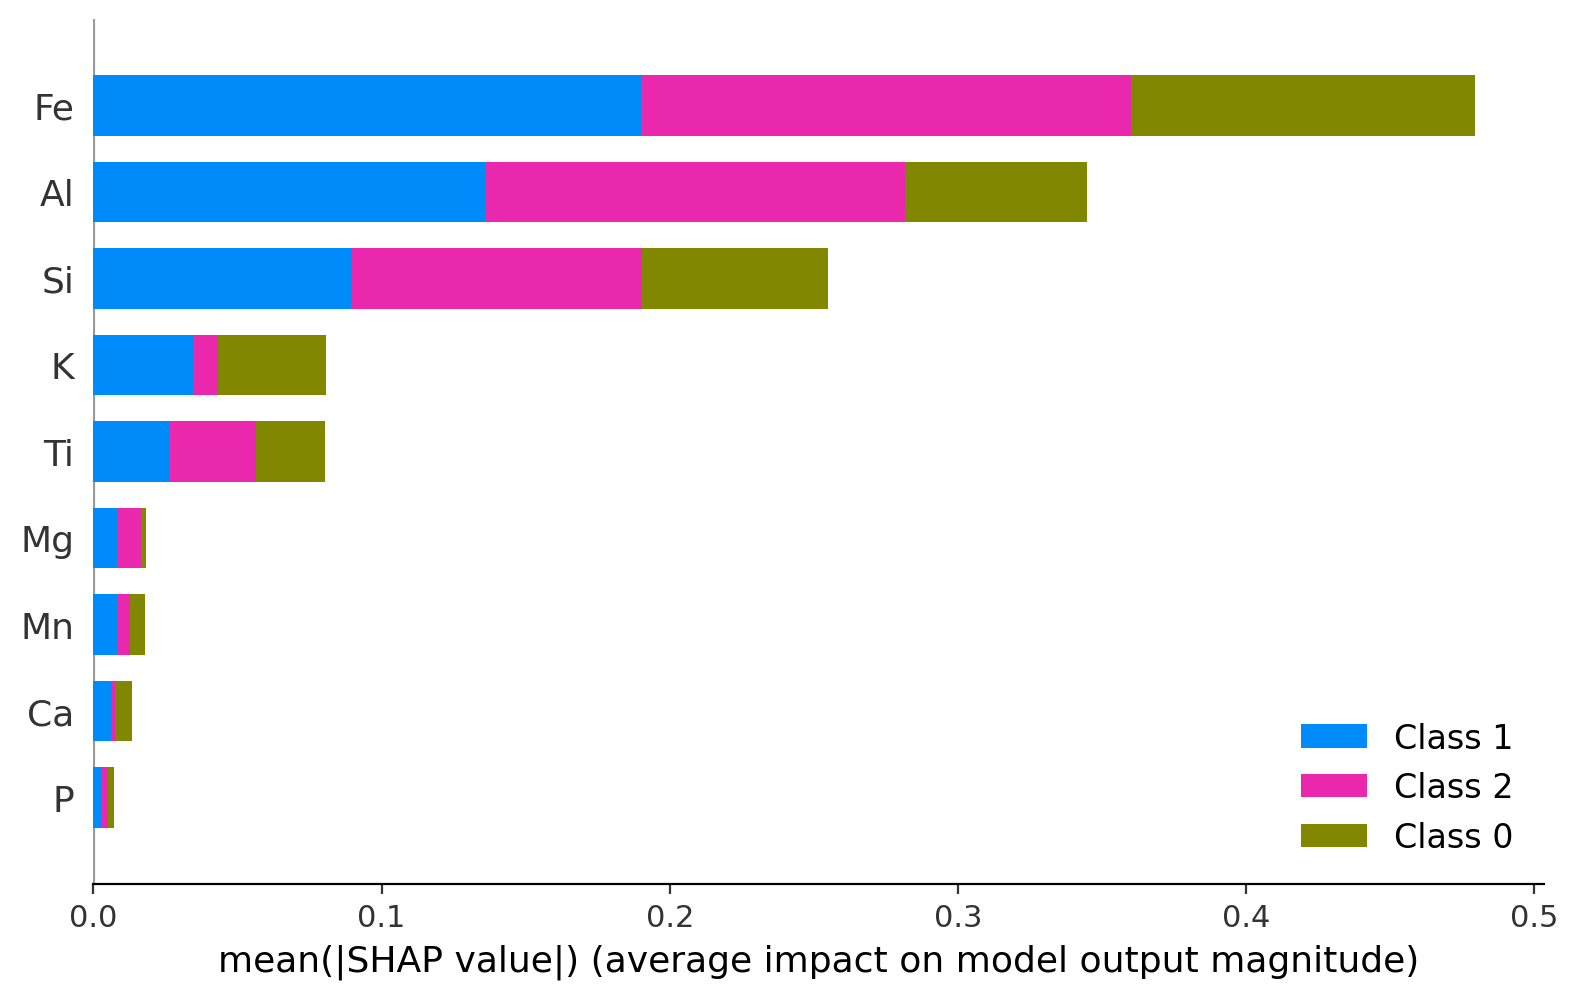

In [45]:
shap.summary_plot(multi_shap_values, x_test, plot_type="bar")

In [47]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0], x)

In [49]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0][0,:], x.iloc[0,:])

In [50]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[1], multi_shap_values[:,:,1][0,:], x.iloc[0,:])

In [51]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[2], multi_shap_values[:,:,2][0,:], x.iloc[0,:])

In [53]:
# visualize the first prediction's explaination with default colors
#shap.initjs()
#shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], x.iloc[0,:])

In [52]:
df_imp = df.copy()
df_imp.drop(['cluster' ], axis = 'columns', inplace=True)

pd.DataFrame(df_imp.columns, rfc.feature_importances_*100)

0
1.553893   Mg
27.468840  Al
19.217968  Si
0.800014    P
5.860729    K
1.191940   Ca
5.152503   Ti
1.824381   Mn
36.929734  Fe

In [55]:
# Predict the classes on the test data
y_pred = rfc.predict(x_test)

In [56]:
# Predict the classes on the test data, and return the probabilities for each class
y_proba = rfc.predict_proba(x_test)

In [57]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [58]:
print(accuracy_score(y_test,y_pred)*100)

100.0


In [59]:
rfc.feature_importances_

array([0.01553893, 0.2746884 , 0.19217968, 0.00800014, 0.05860729,
       0.0119194 , 0.05152503, 0.01824381, 0.36929734])

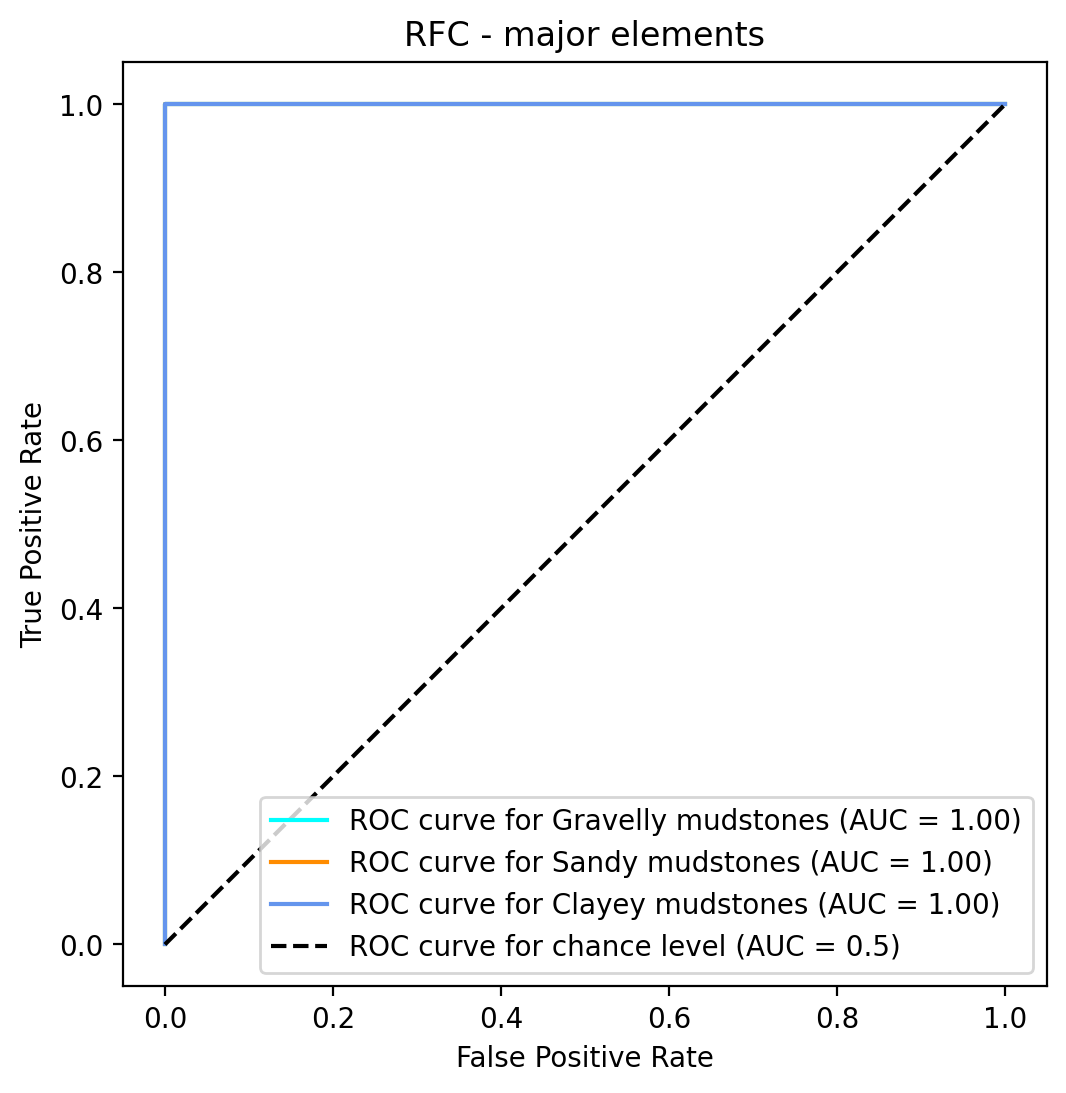

In [60]:
rfc_roc = plot_roc_multiclass(y_train, y_test, rfc.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "RFC - major elements")
rfc_roc

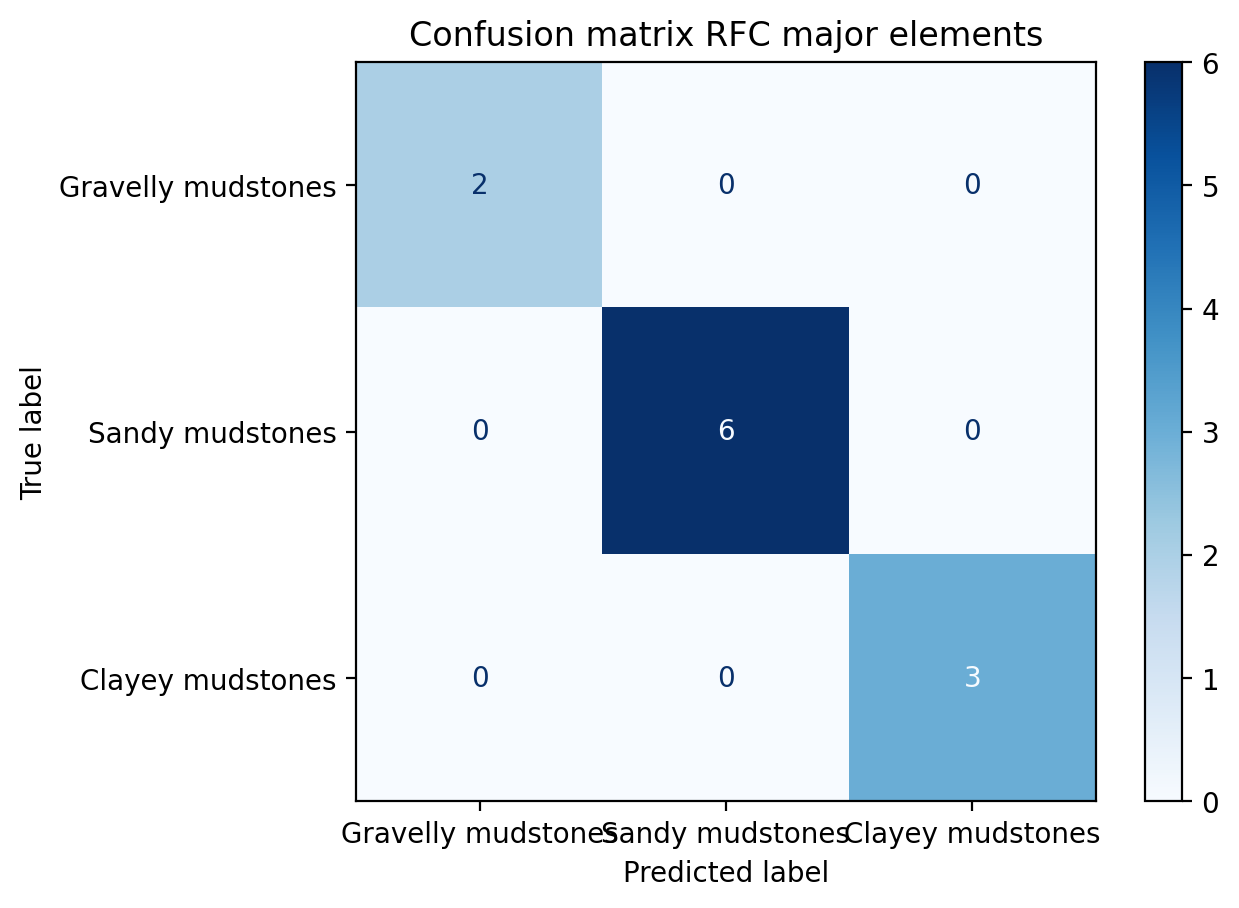

In [61]:
title_options = [
    ("Confusion matrix RFC major elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        rfc,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

In [62]:
from pprint import pprint

In [63]:
train_features = x_train
train_labels = y_train
test_features = x_test
test_labels = y_test

In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [65]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(train_features, train_labels)
#rf_random.best_params_

4. AdaBoostClassifier

In [66]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=0)
adb.fit(x_train,y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=0)

In [67]:
y_pred=adb.predict(x_test)
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",adb.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Confusion Matrix:
 [[2 0 0]
 [0 6 0]
 [0 0 3]]
Training Score:
 100.0
Mean Squared Error:
 0.0
R2 score is:
 1.0


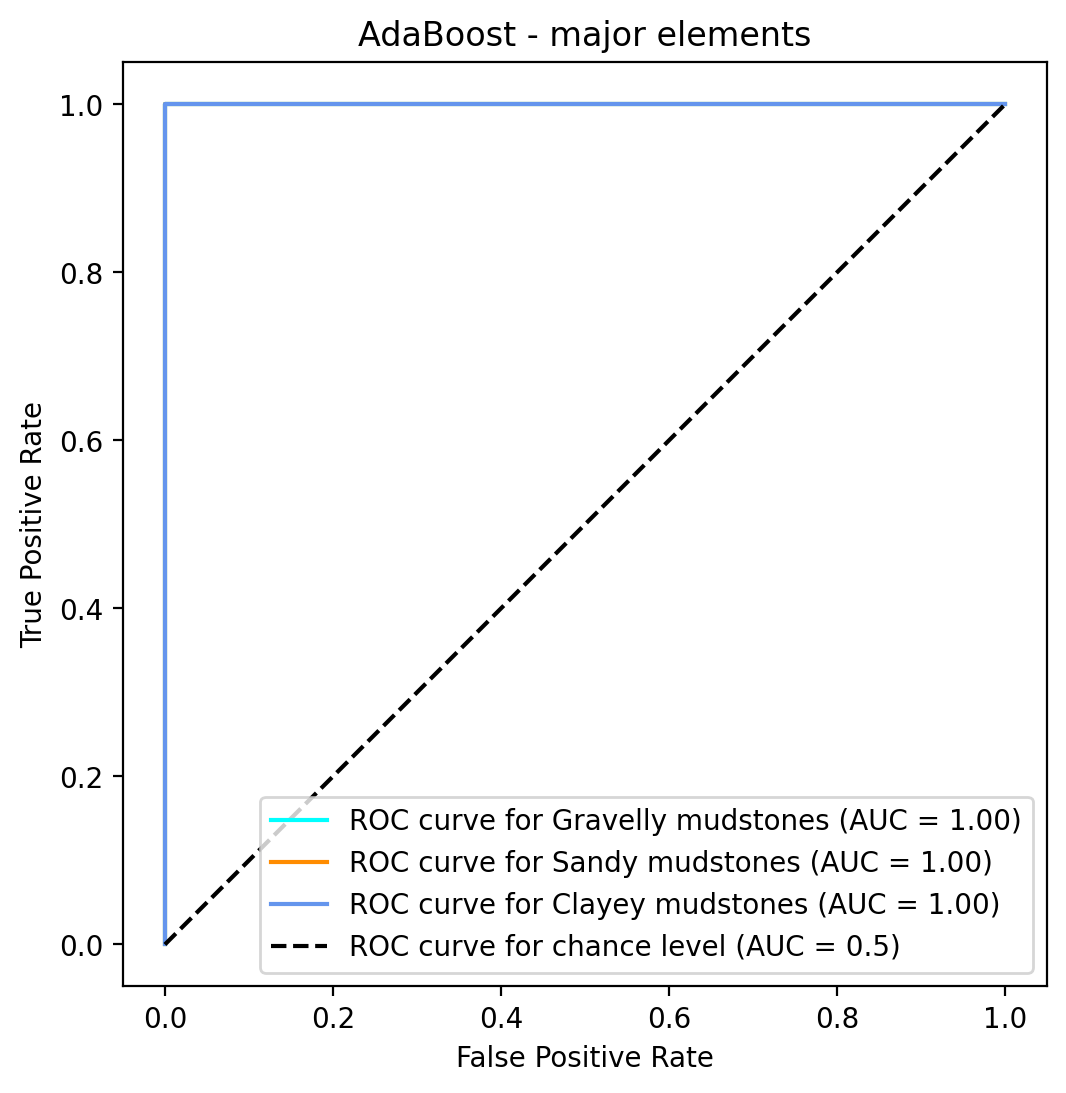

In [68]:
adb_roc = plot_roc_multiclass(y_train, y_test, adb.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "AdaBoost - major elements")
adb_roc

In [69]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'])
print(report)

                    precision    recall  f1-score   support

Gravelly mudstones       1.00      1.00      1.00         2
   Sandy mudstones       1.00      1.00      1.00         6
  Clayey mudstones       1.00      1.00      1.00         3

          accuracy                           1.00        11
         macro avg       1.00      1.00      1.00        11
      weighted avg       1.00      1.00      1.00        11



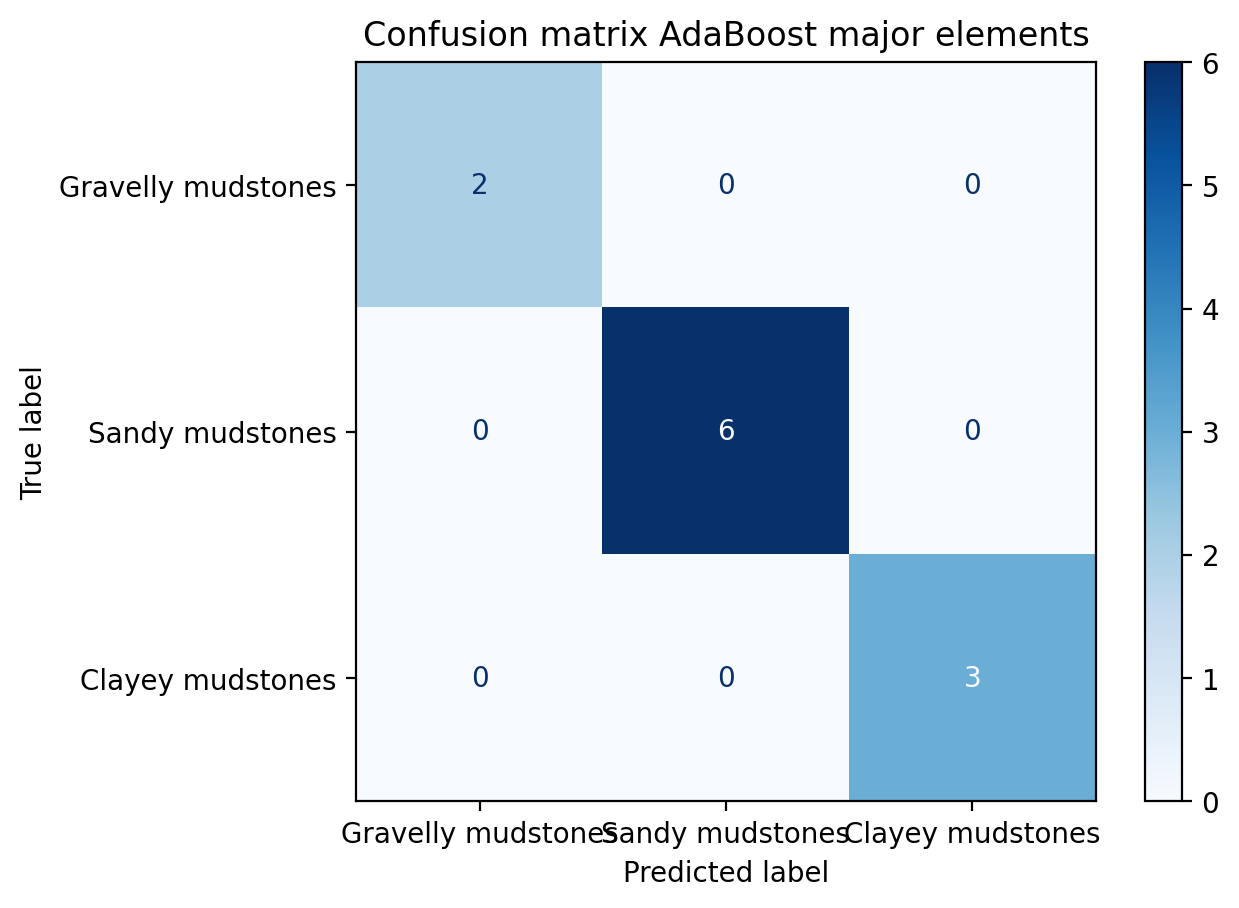

In [70]:
title_options = [
    ("Confusion matrix AdaBoost major elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        adb,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

In [71]:
from sklearn.metrics import roc_auc_score

# Generate class membership probabilities
y_preb_probs = adb.predict_proba(x_test)

roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

np.float64(1.0)

In [72]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:

        #creating a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [73]:
roc_auc_dict = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_dict

{1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}

In [74]:
print(accuracy_score(y_test,y_pred)*100)

100.0


In [75]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [76]:
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#data

XAI

In [77]:
# Fits the explainer
explainer = shap.Explainer(adb.predict, x_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

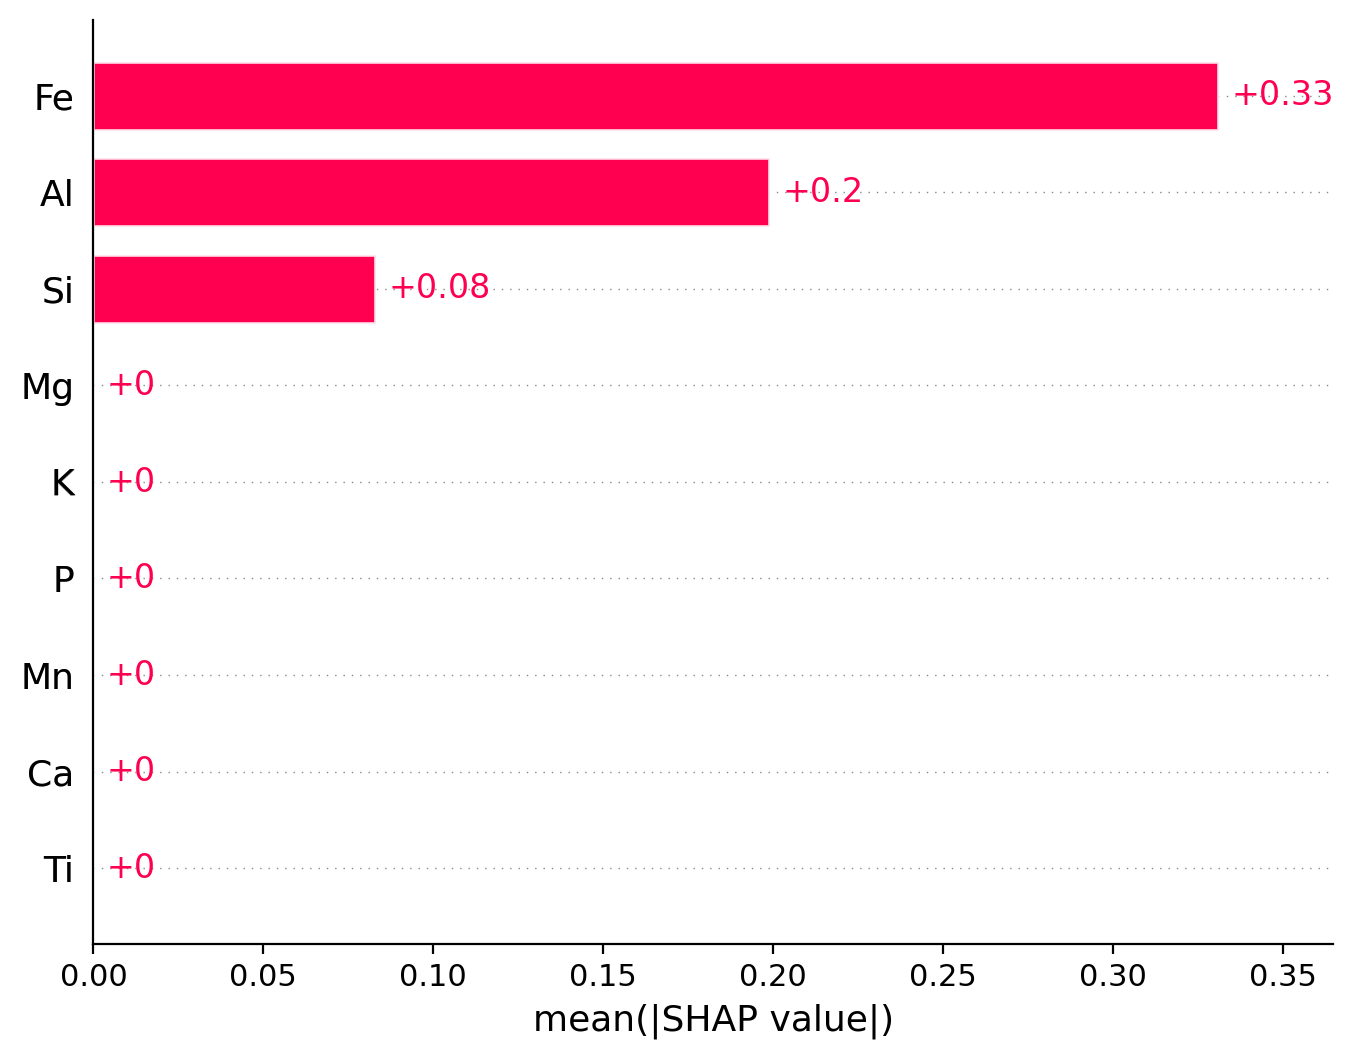

In [78]:
shap.plots.bar(shap_values)

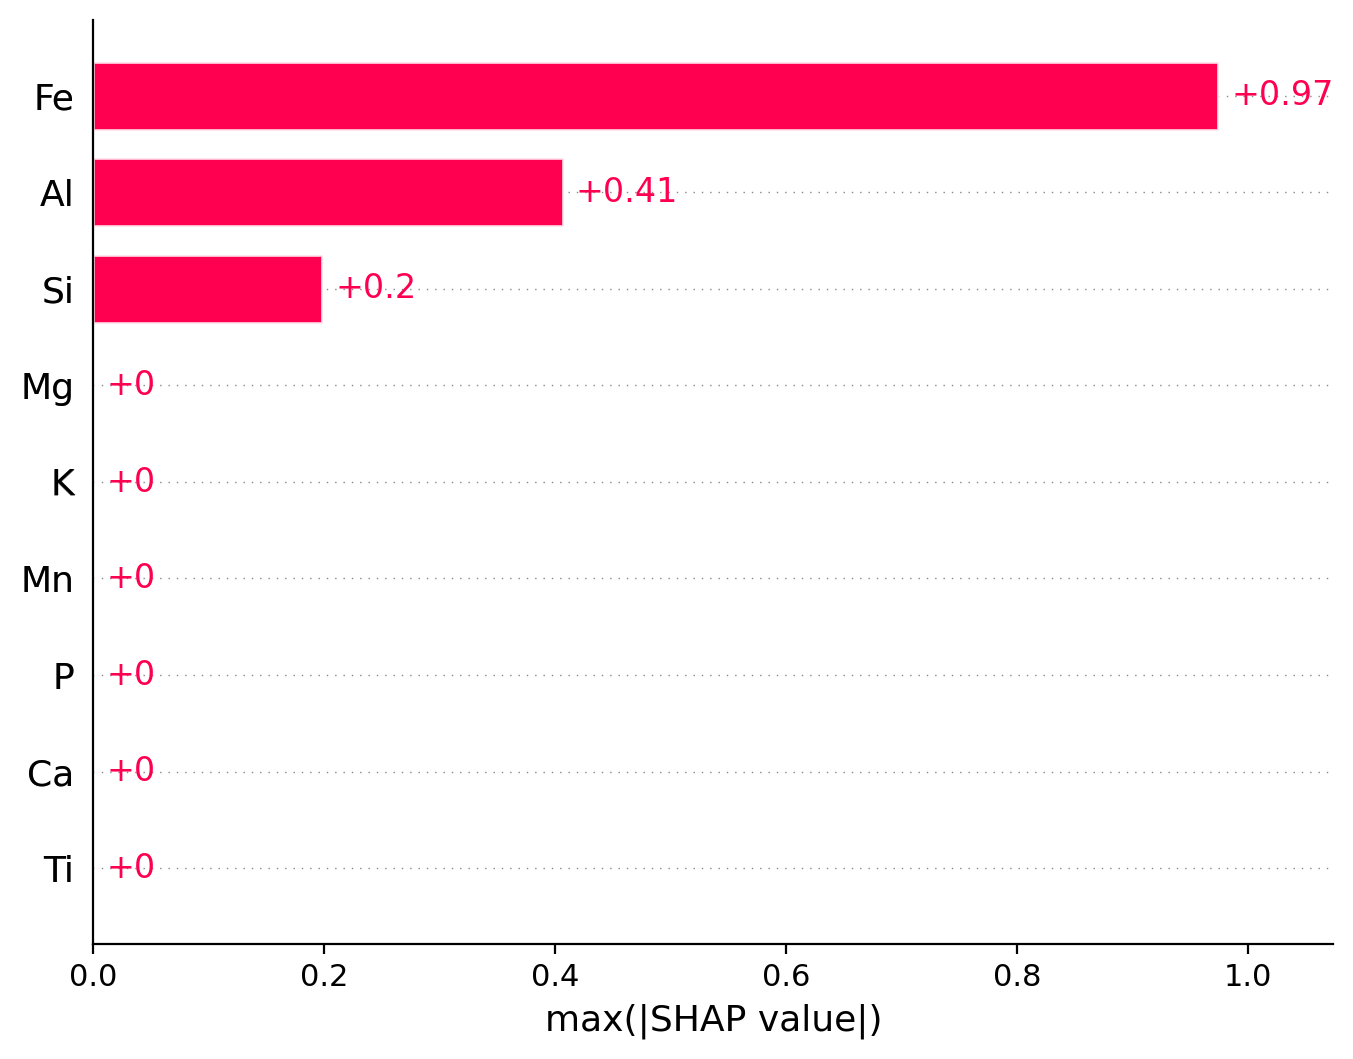

In [79]:
shap.plots.bar(shap_values.abs.max(0))

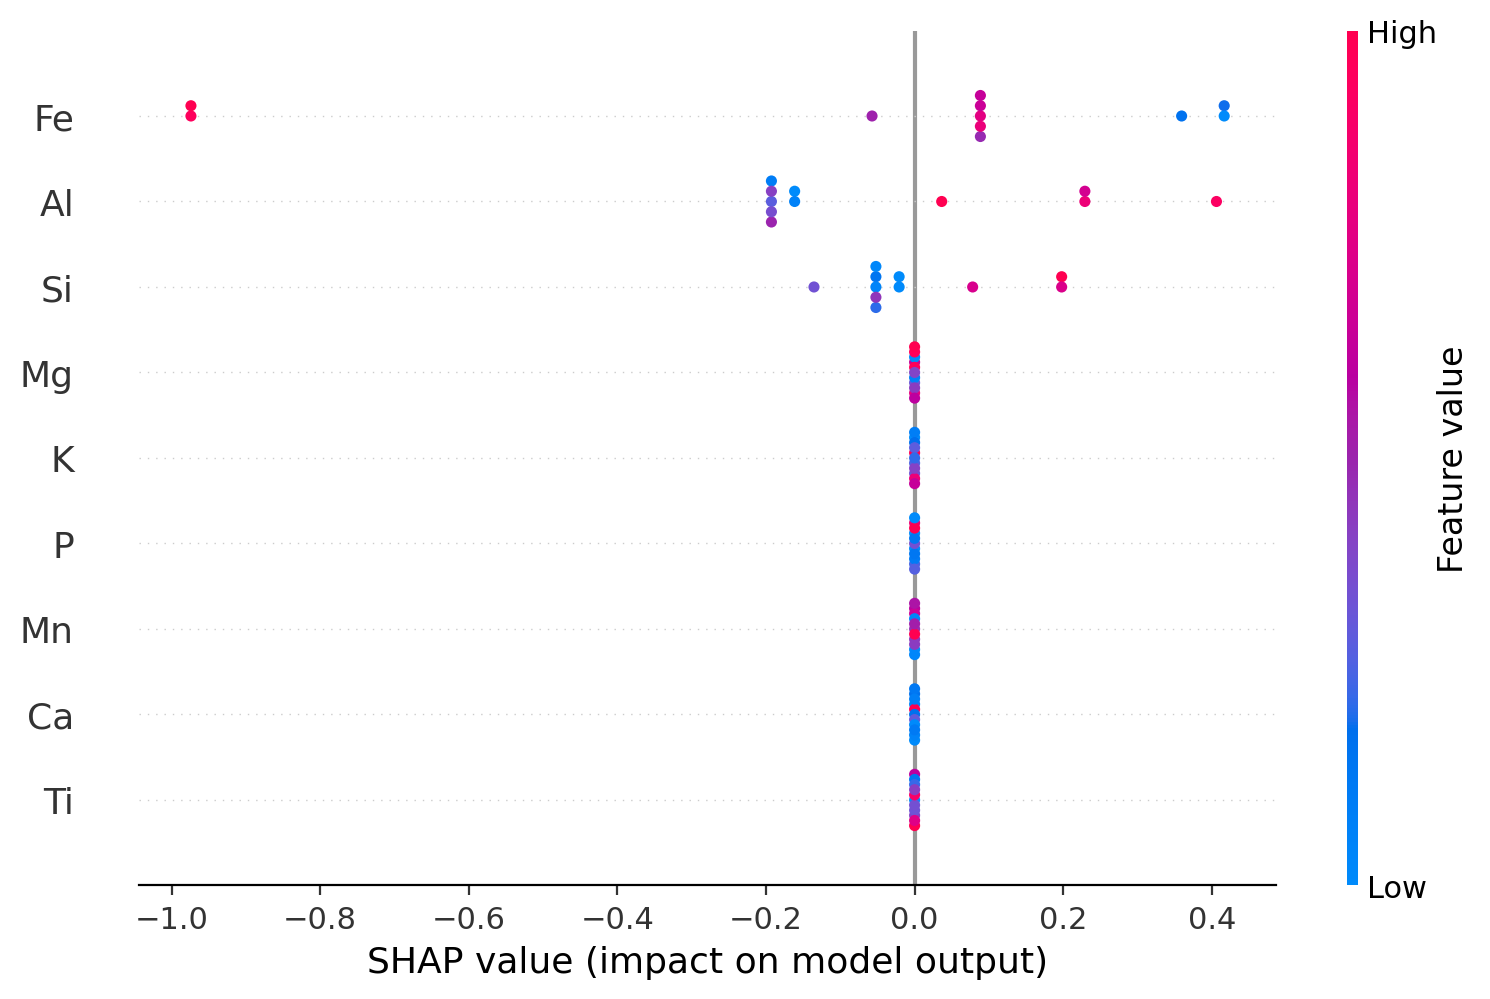

In [80]:
shap.summary_plot(shap_values)

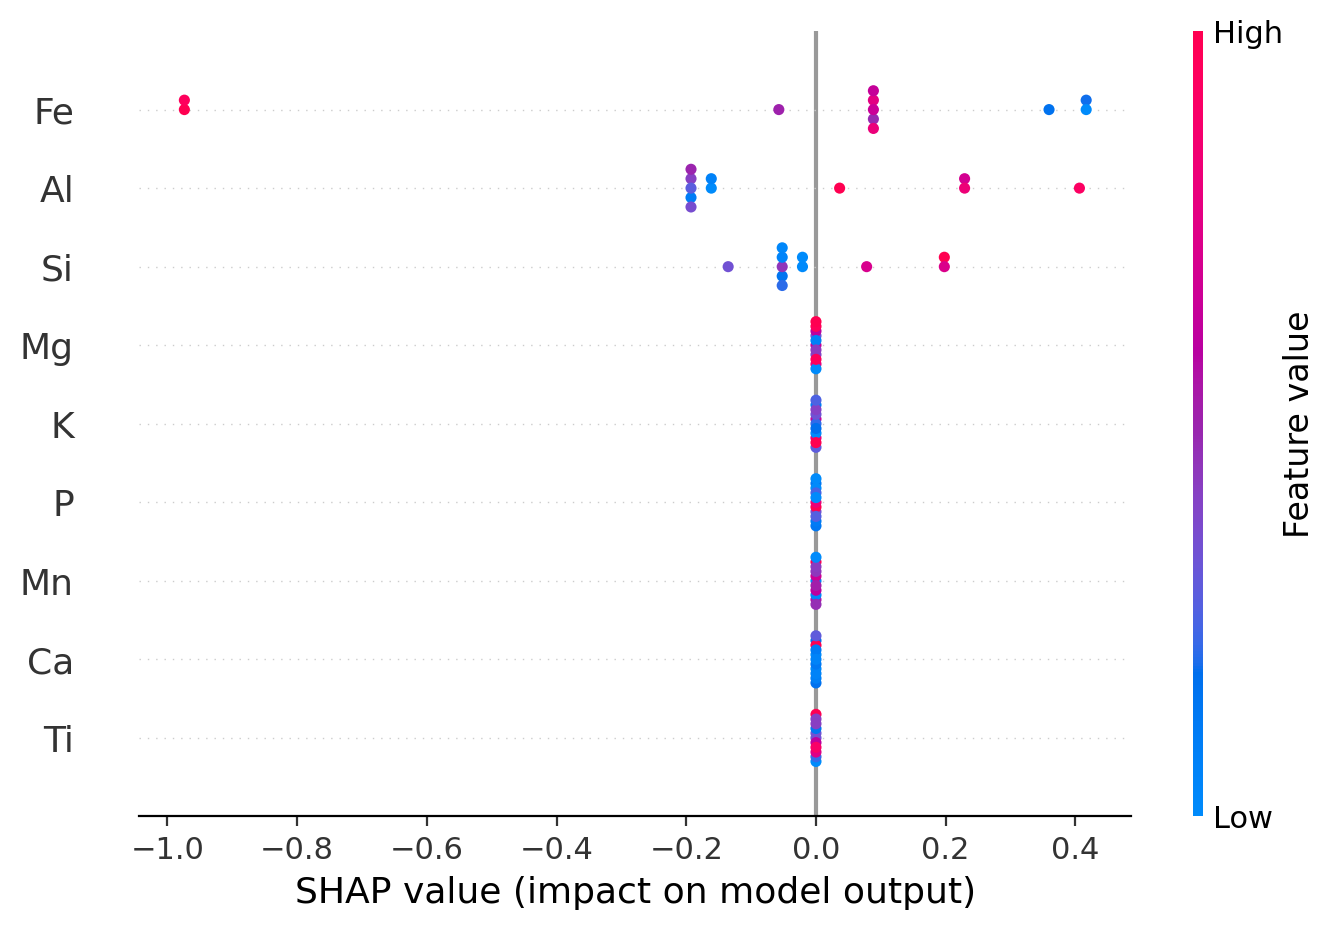

In [81]:
# or
shap.plots.beeswarm(shap_values)

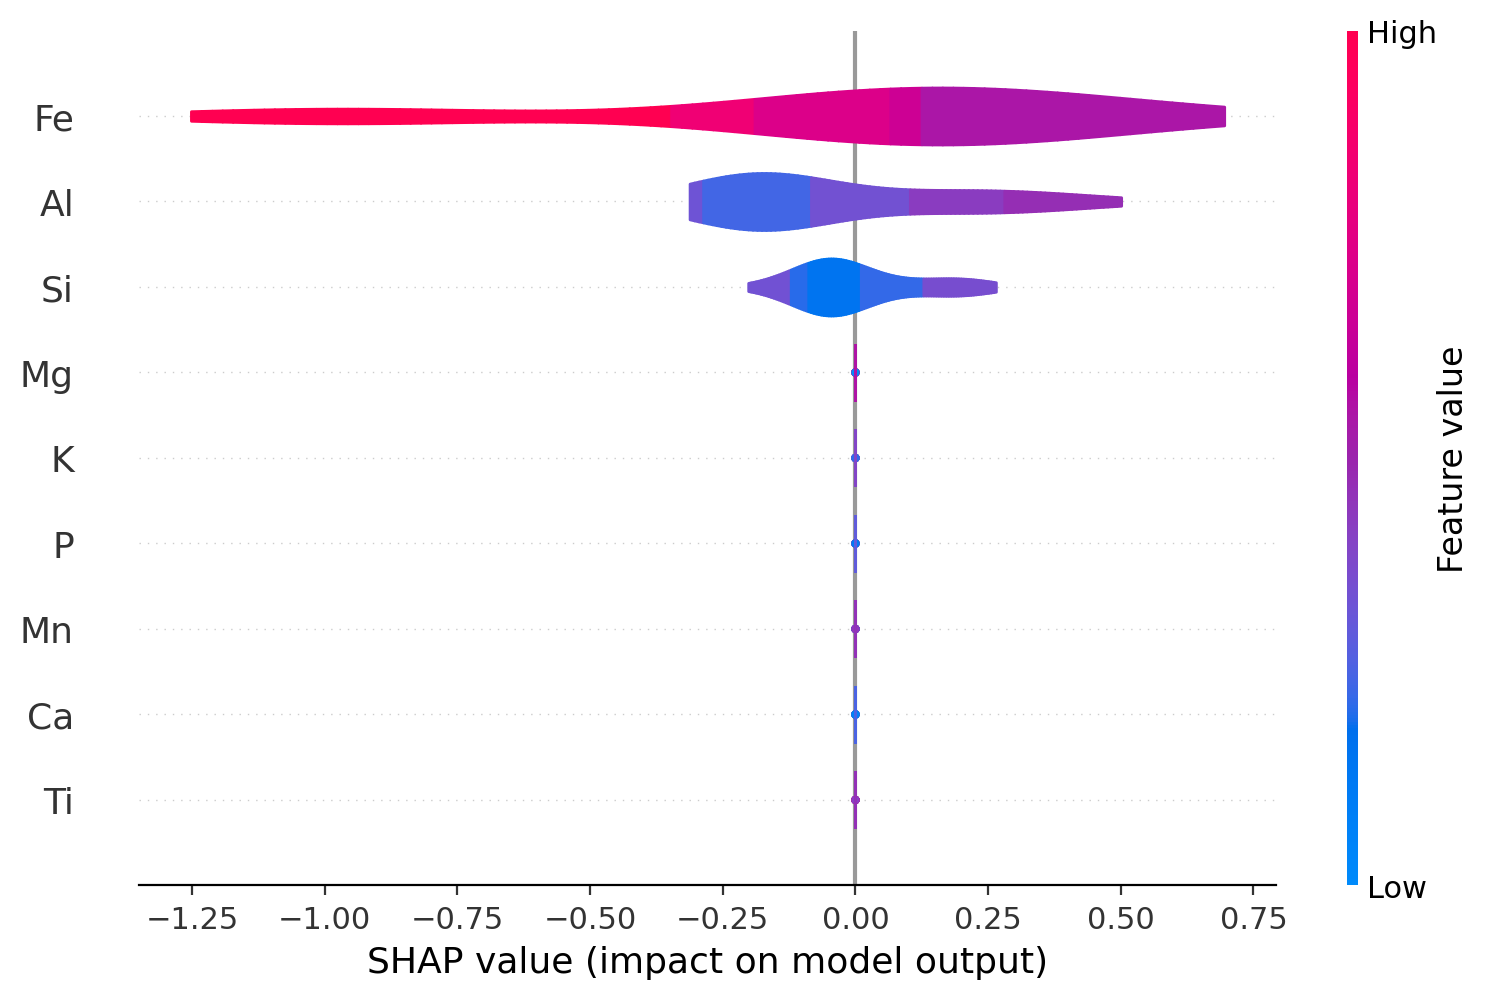

In [82]:
shap.summary_plot(shap_values, plot_type='violin')

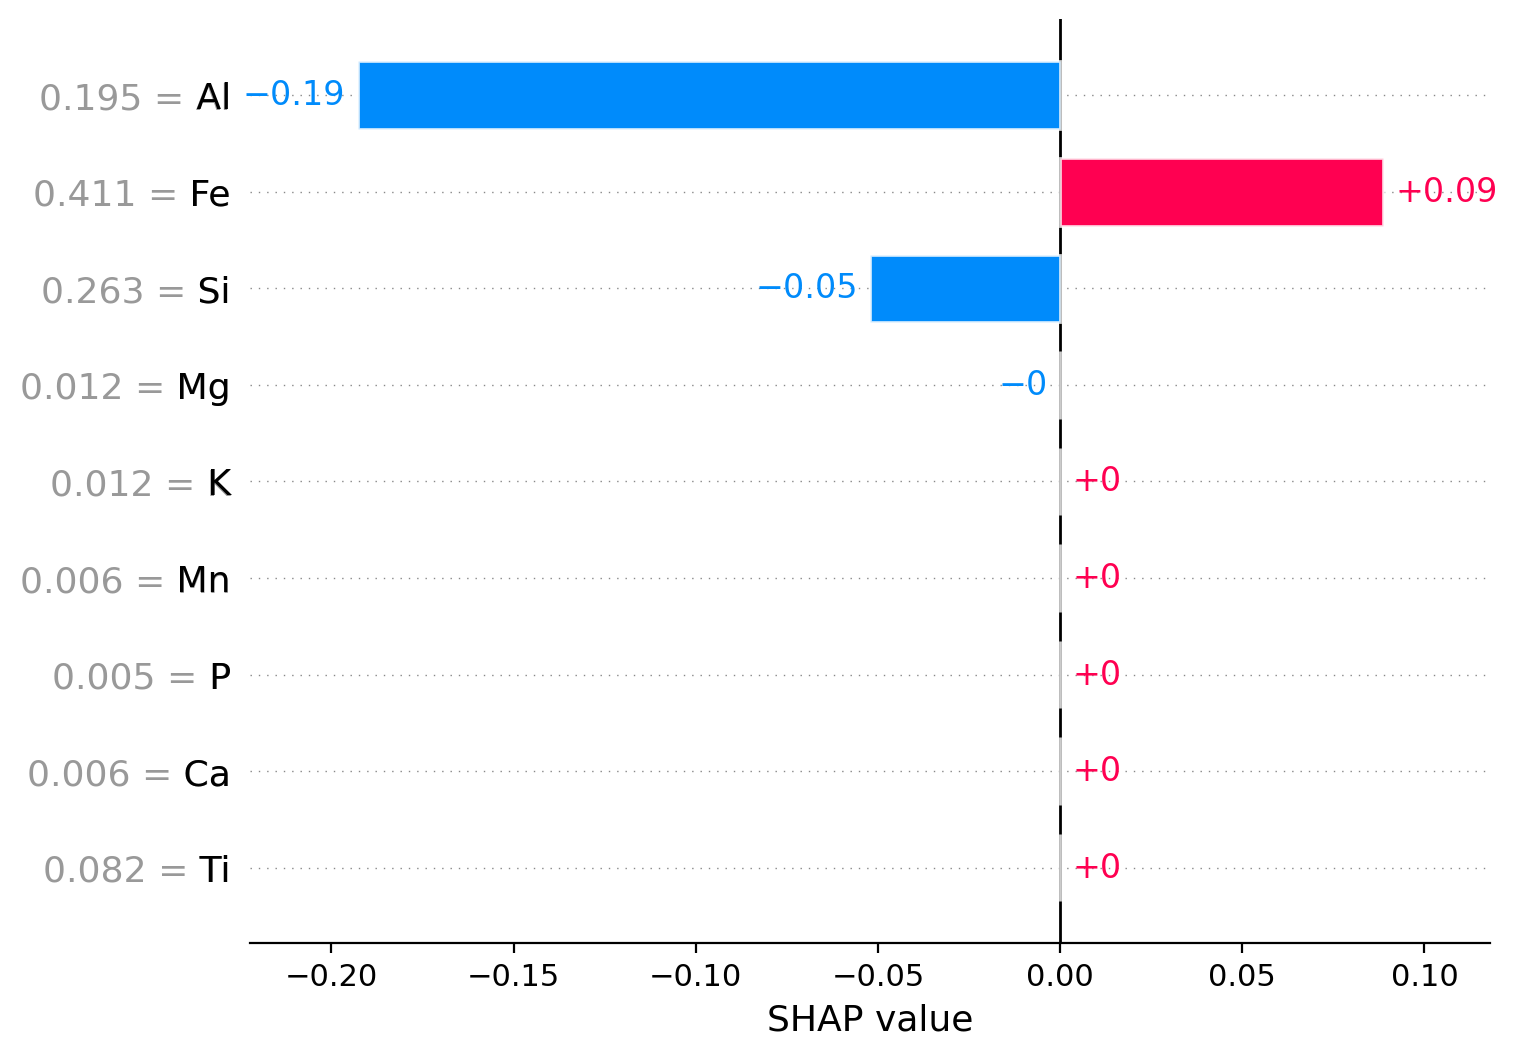

In [83]:
#Local bar plot
shap.plots.bar(shap_values[0])

In [87]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rfc)
    shap_values_Model = explainerModel.shap_values(x)
    p = shap.force_plot(explainerModel.expected_value[j], shap_values_Model[:,:,j], x)
    return(p)

In [88]:
shap.initjs()
shap_plot(0)

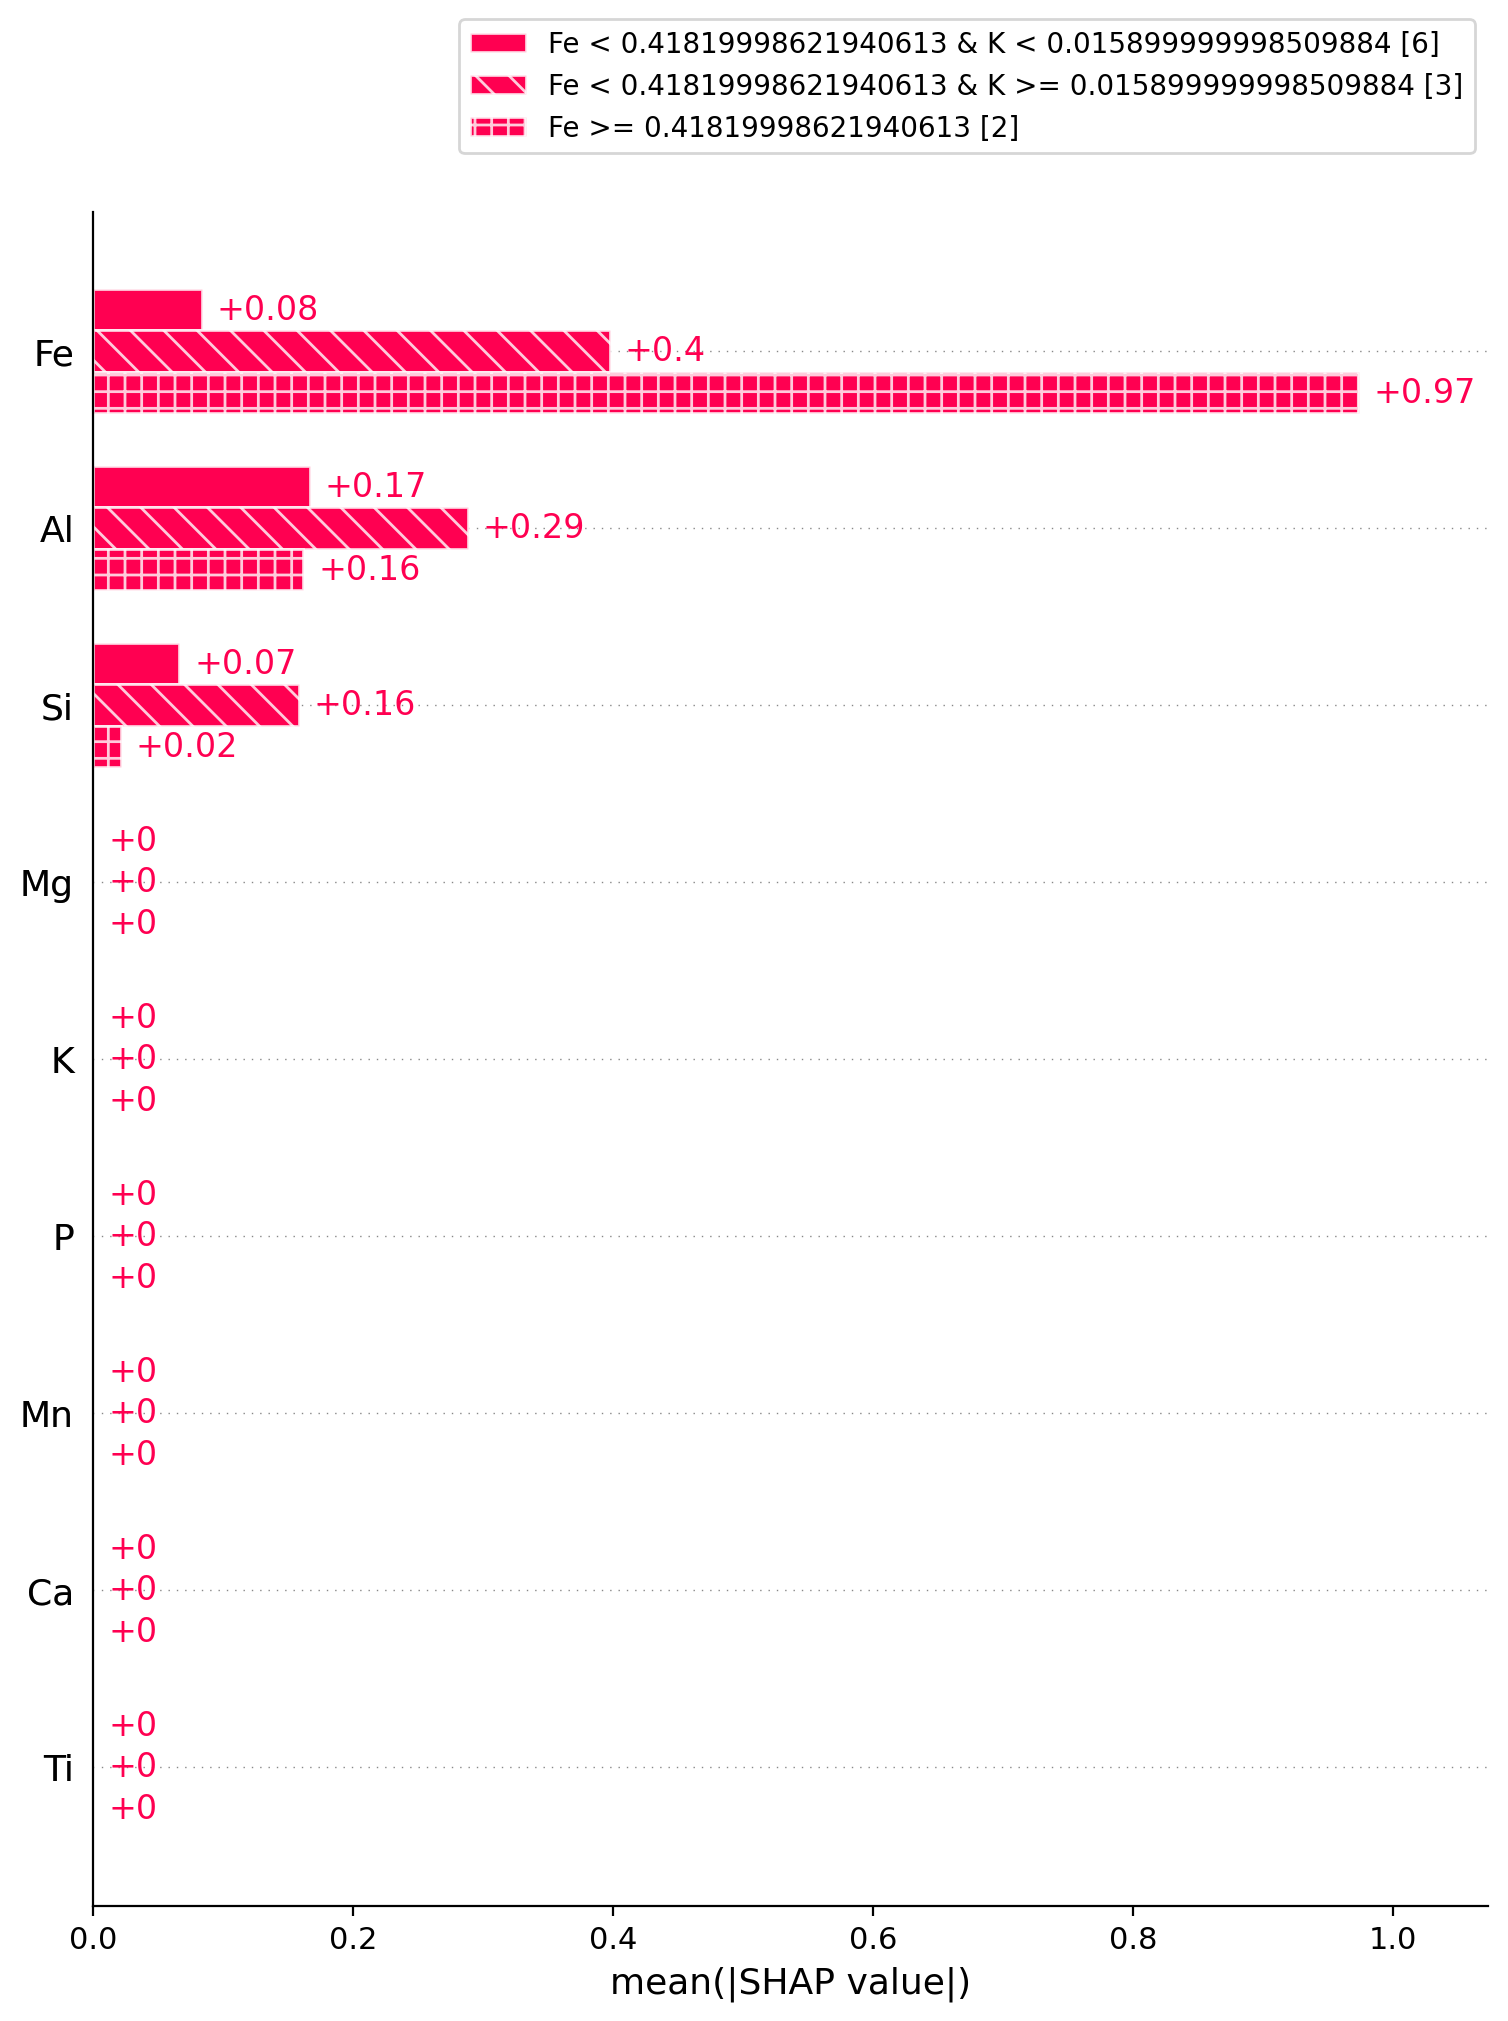

In [89]:
#shap.plots.bar(shap_values.cohorts(3).abs.mean(0))
shap.plots.bar(shap_values.cohorts(3).abs.mean(0), show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(11)
fig.set_figwidth(9)
#plt.rcParams['font.size'] = '12'
ax = plt.gca() #gca means "get current axes"
leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()

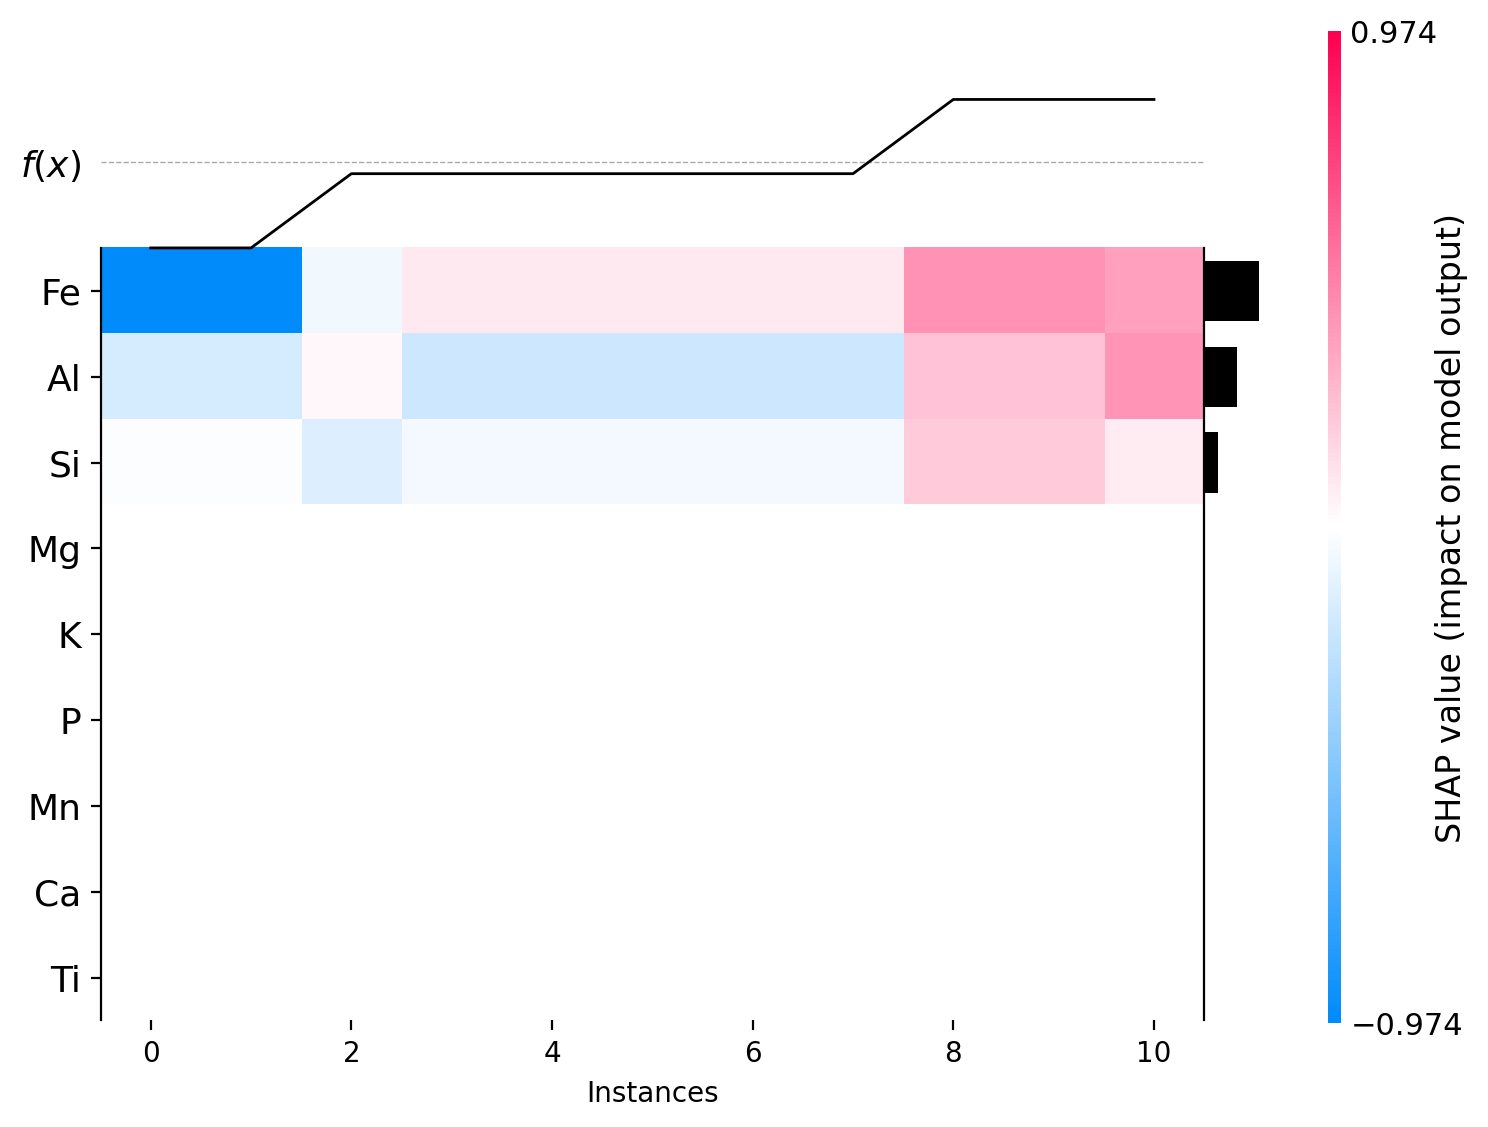

<Axes: xlabel='Instances'>

In [90]:
shap.plots.heatmap(shap_values[0:])

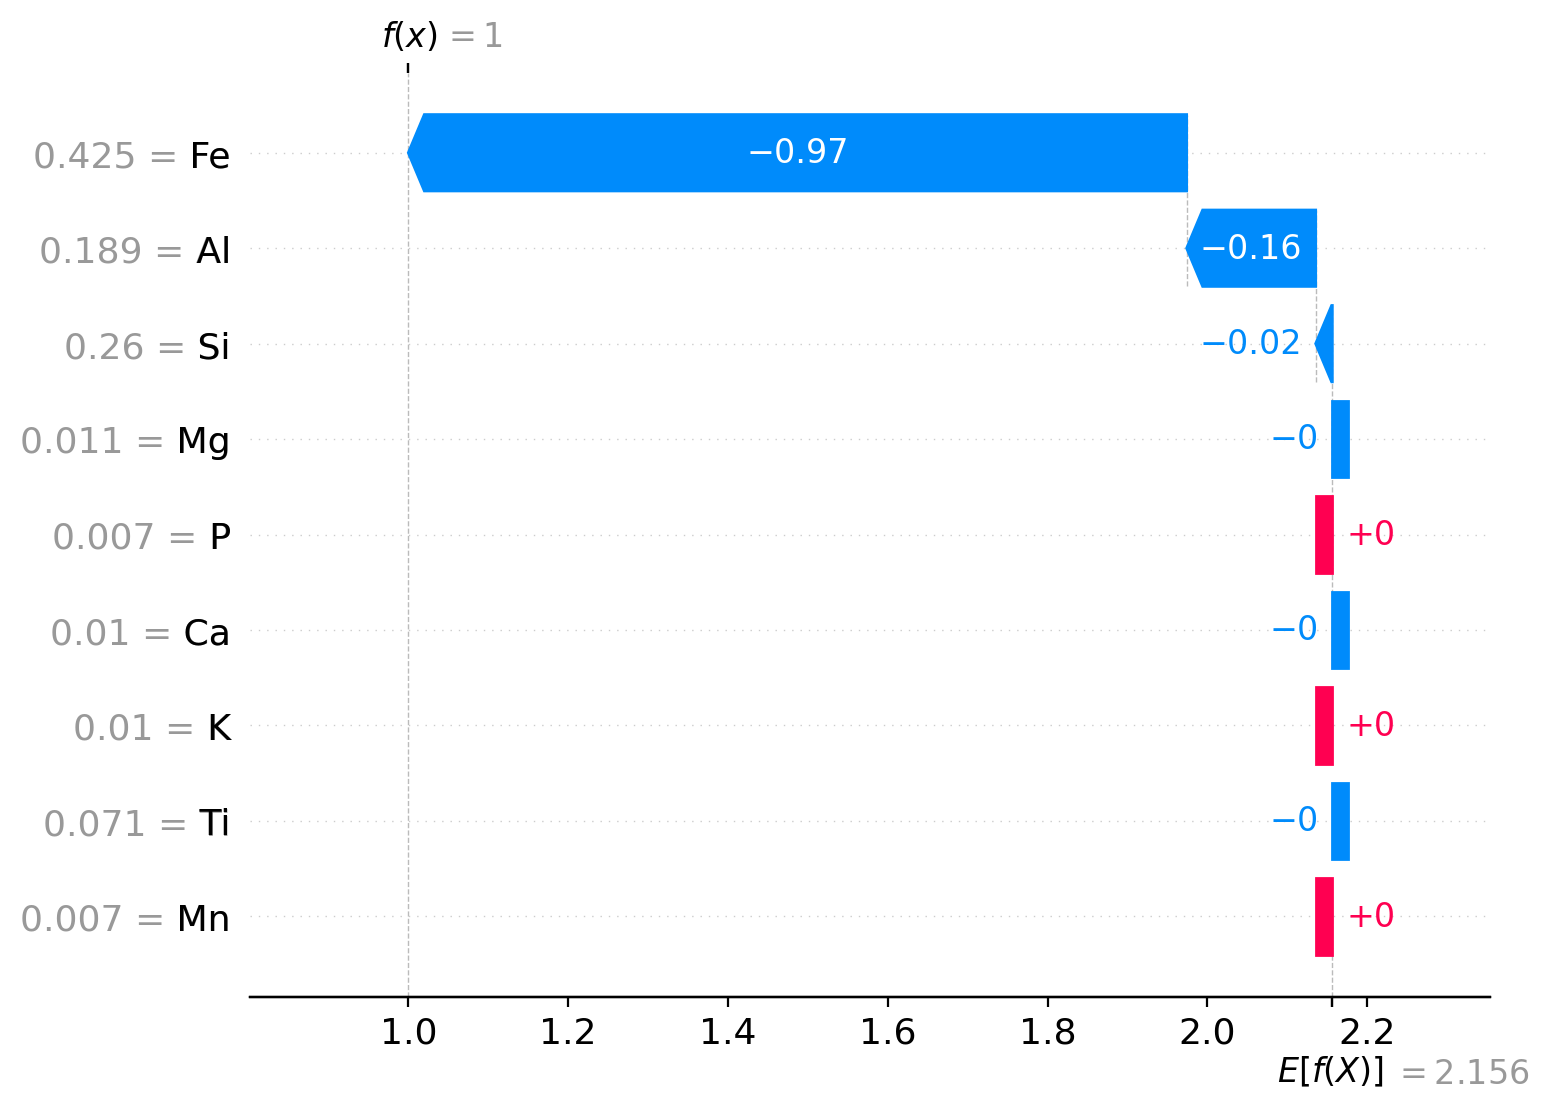

In [91]:
#Waterfall plot
shap.plots.waterfall(shap_values[3])
#The waterfall plot has the same information, represented in a different manner.
#Here we can see how the sum of all the SHAP values equals the difference between
#the prediction f(x) and the expected value E[f(x)].

In [92]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rfc)
multi_shap_values = explainer.shap_values(x)

In [93]:
df.columns

Index(['cluster', 'Mg', 'Al', 'Si', 'P', 'K', 'Ca', 'Ti', 'Mn', 'Fe'], dtype='object')

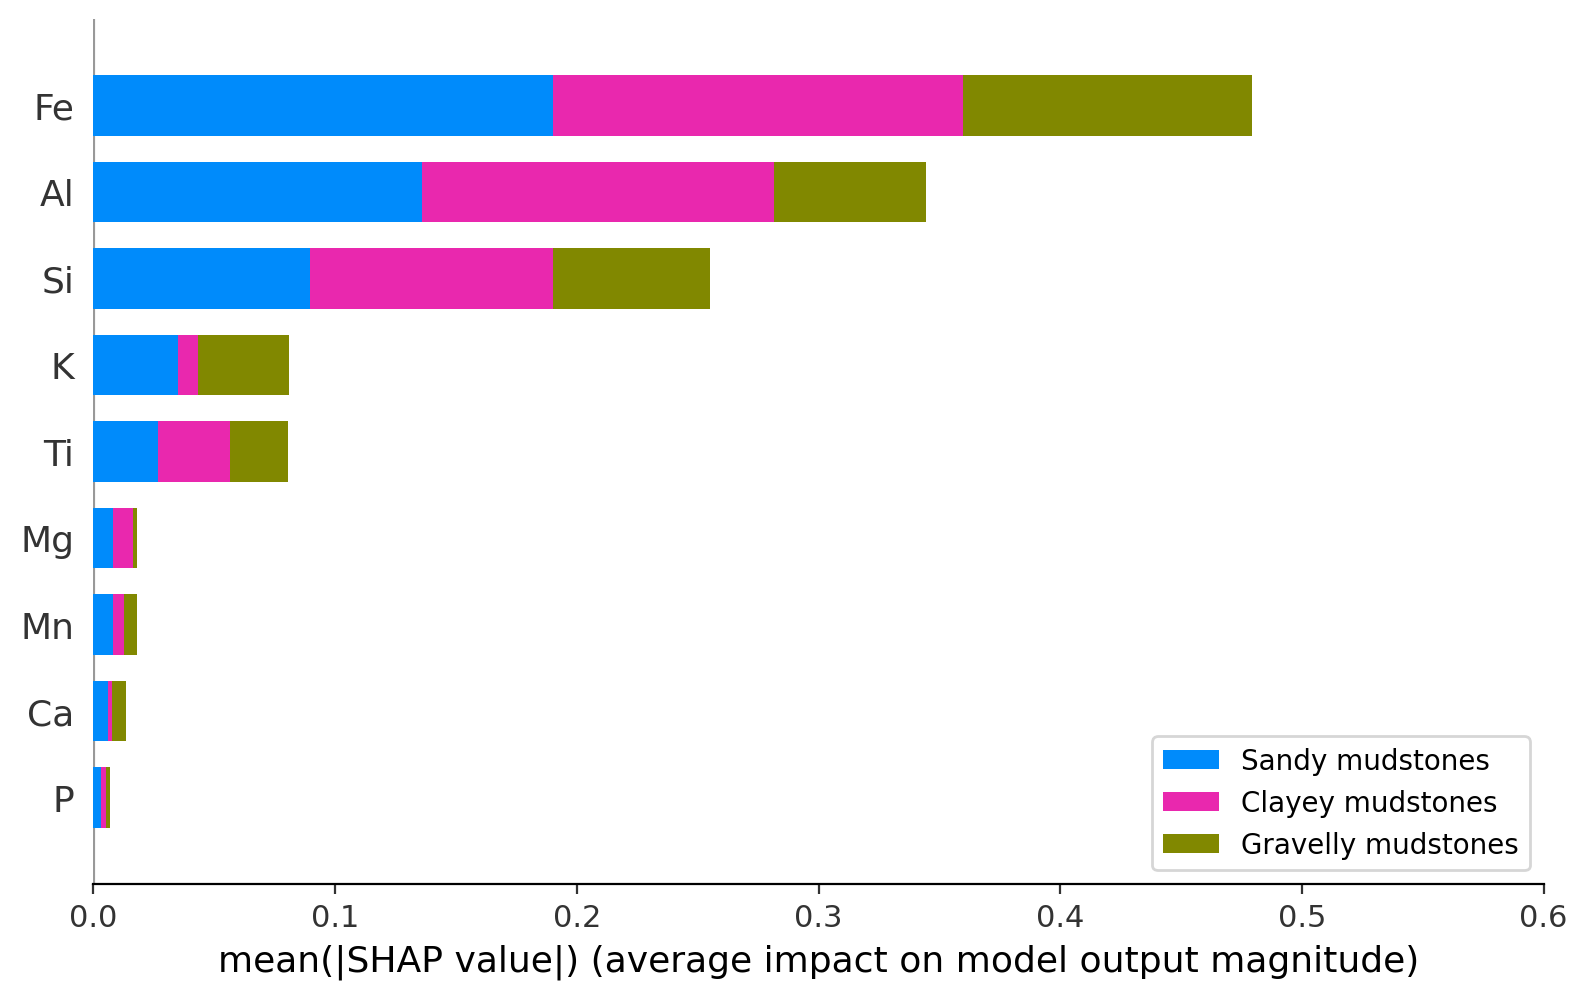

In [94]:
shap.summary_plot(multi_shap_values, x_test, plot_type="bar",class_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], show=False)

ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(0, 0.6)
ax.legend(loc='lower right')
plt.show()

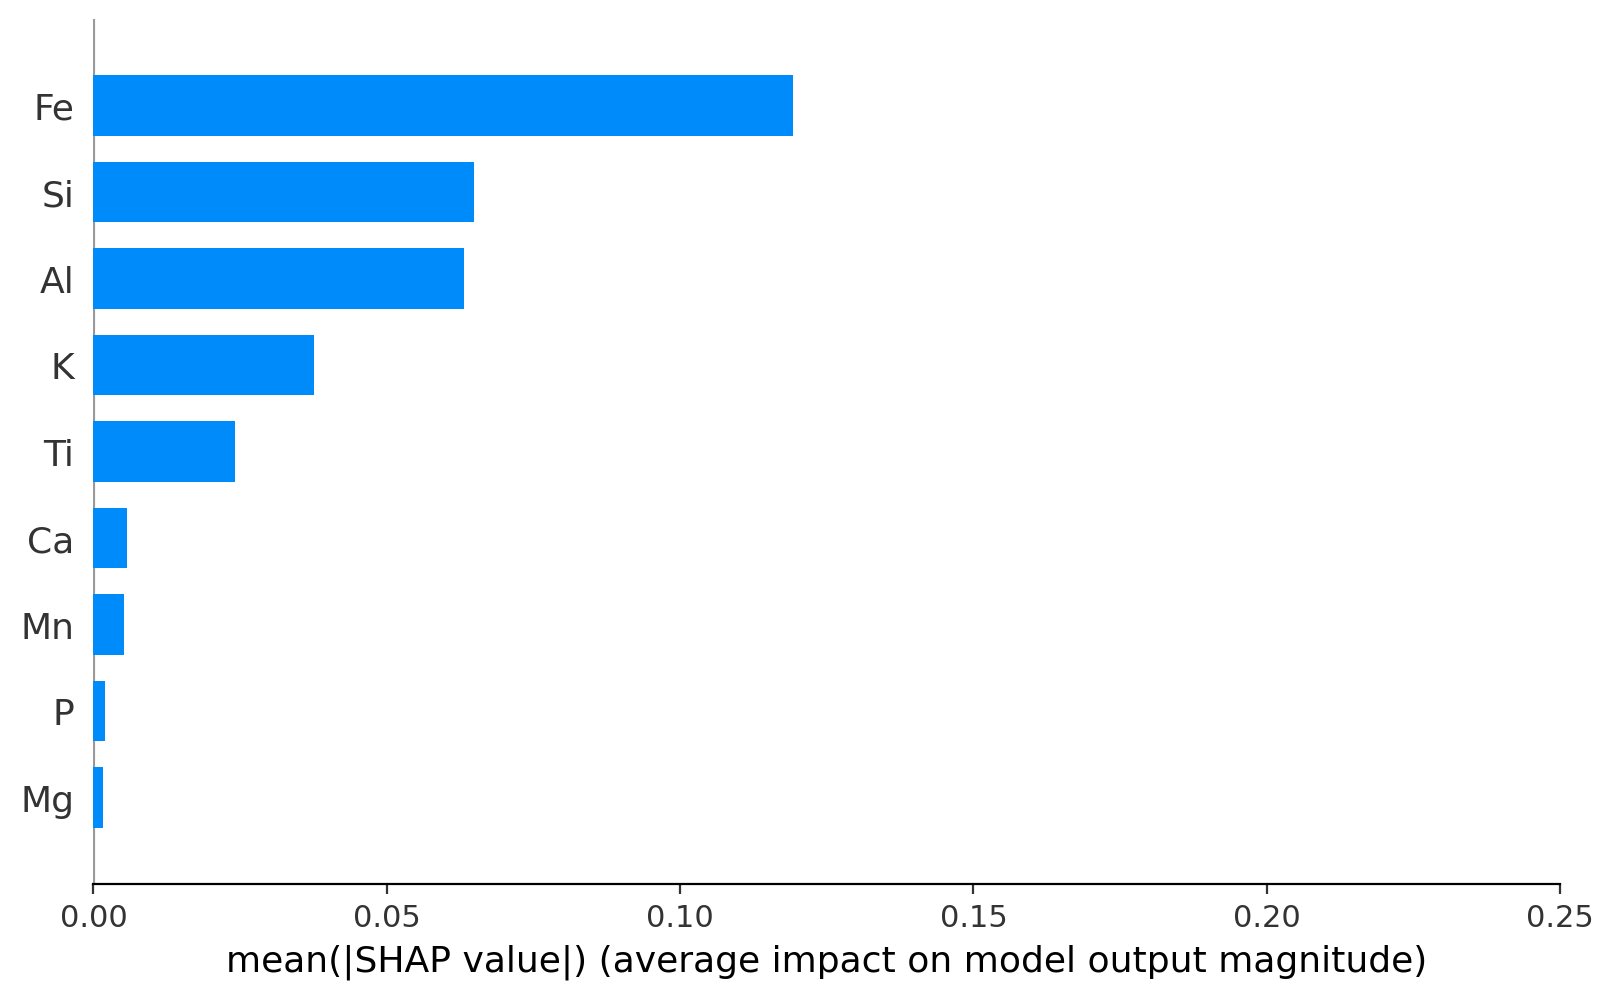

In [96]:
shap.summary_plot(multi_shap_values[:,:,0], x_test, plot_type="bar",class_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], show=False)
ax = plt.gca()
ax.set_xlim(0, 0.25)
plt.show()

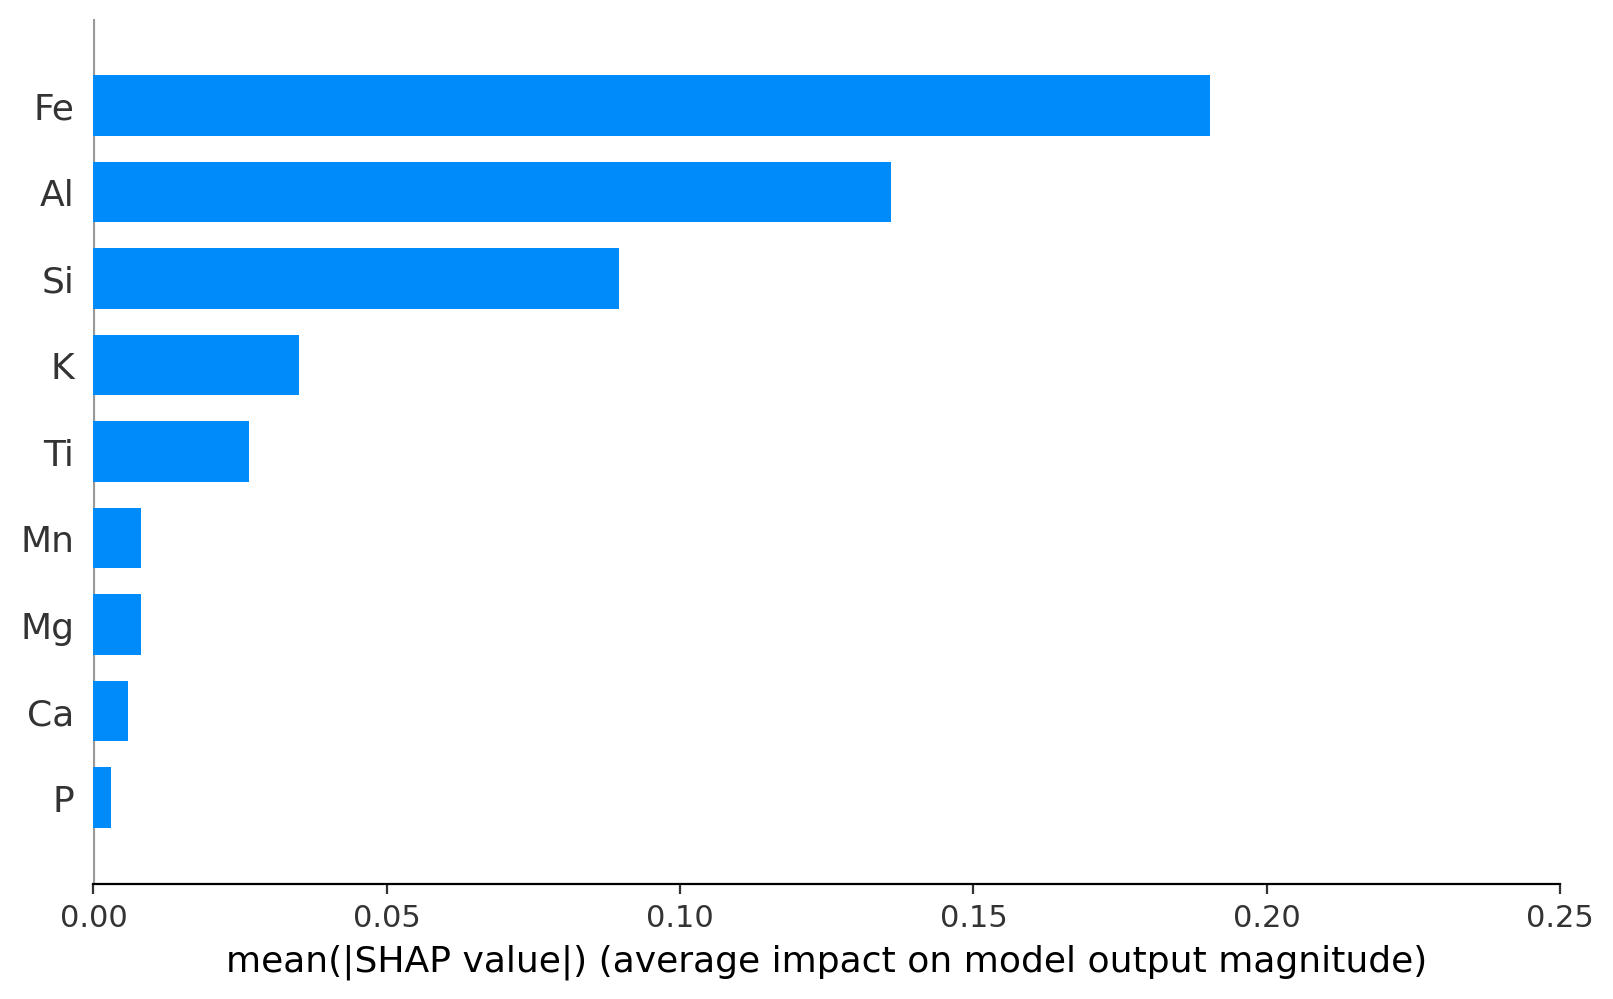

In [97]:
shap.summary_plot(multi_shap_values[:,:,1], x_test, plot_type="bar",class_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], show=False)
ax = plt.gca()
ax.set_xlim(0, 0.25)
plt.show()

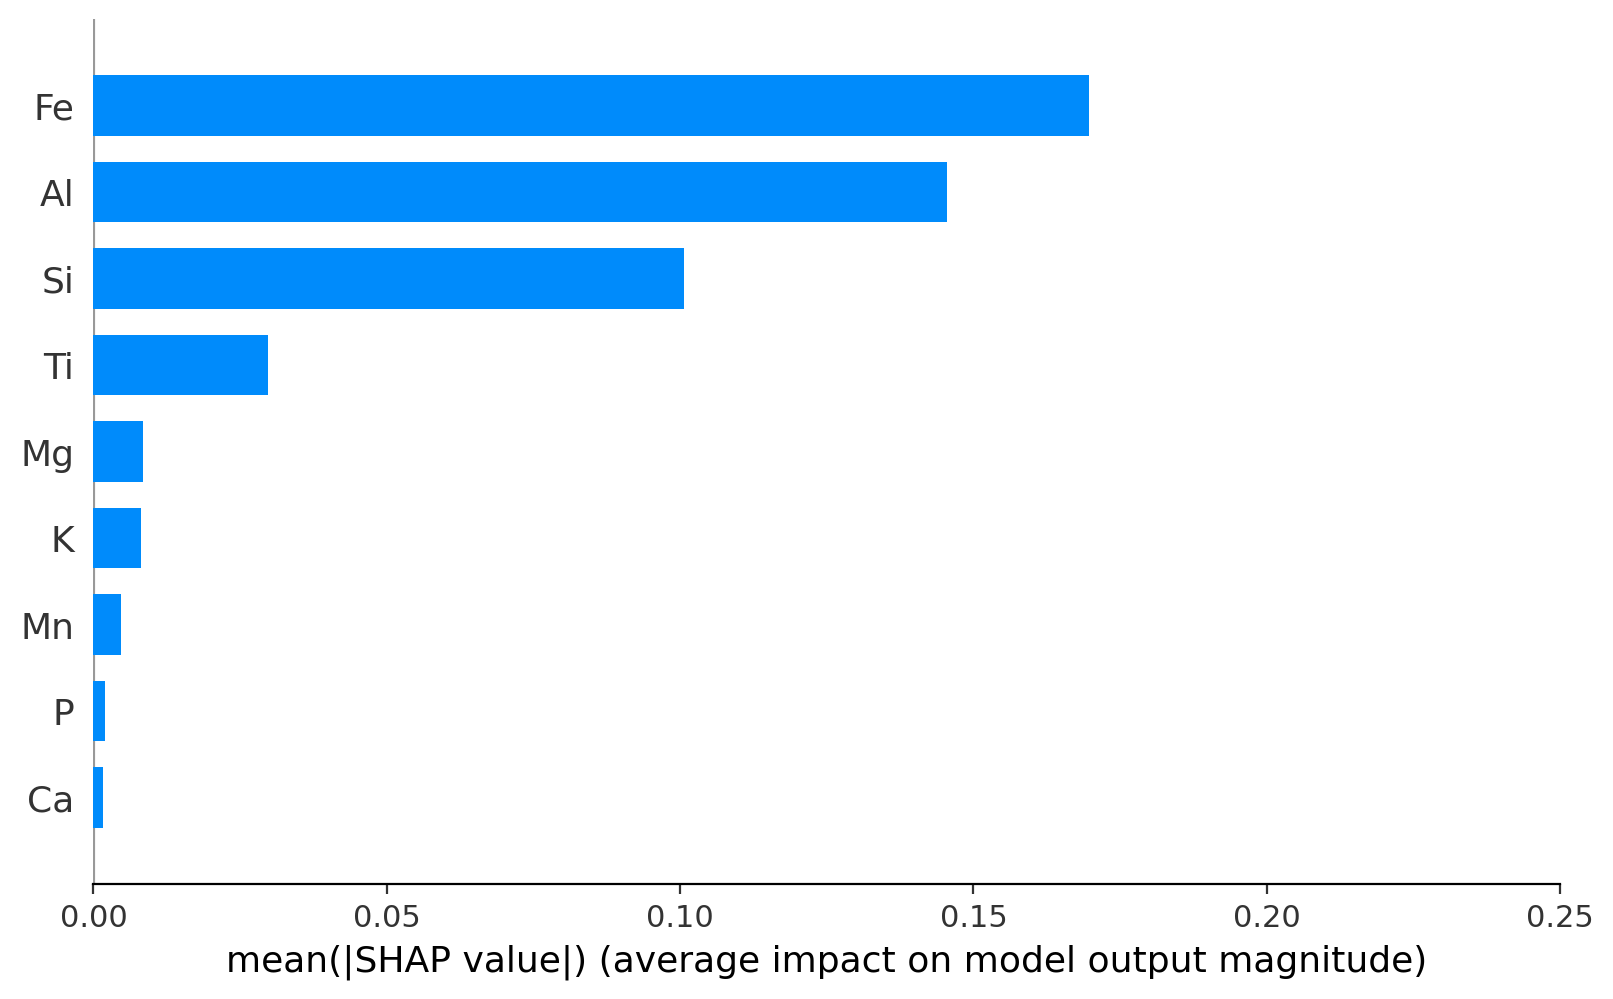

In [98]:
shap.summary_plot(multi_shap_values[:,:,2], x_test, plot_type="bar",class_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], show=False)
ax = plt.gca()
ax.set_xlim(0, 0.25)
plt.show()

In [100]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0], x)

In [101]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0][0,:], x.iloc[0,:])

In [102]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[1], multi_shap_values[:,:,1][0,:], x.iloc[0,:])

In [103]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[2], multi_shap_values[:,:,2][0,:], x.iloc[0,:])

# Testing the model in the BC core samples

In [104]:
# LOADING THE DATASET
my_sheet = 'S2-BC' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = 'FRX-sondeo-lagunaCopia de 53572_results-MJ.xlsx' # change it to the name of your excel file
df_bc = read_excel(file_name, sheet_name = my_sheet)

In [105]:
df_bc*100

Unnamed: 0  Cm muestreo    Na  \
0   TEN20-S2-BC-35TEN20-S2-BC-35TEN20-S2-BC-35TEN2...         3500   NaN   
1   TEN20-S2-BC-110TEN20-S2-BC-110TEN20-S2-BC-110T...        11000  0.06   
2   TEN20-S2-BC-130TEN20-S2-BC-130TEN20-S2-BC-130T...        13000  0.77   
3   TEN20-S2-BC-150TEN20-S2-BC-150TEN20-S2-BC-150T...        15000  0.28   
4   TEN20-S2-BC-160TEN20-S2-BC-160TEN20-S2-BC-160T...        16000  0.14   
5   TEN20-S2-BC-180TEN20-S2-BC-180TEN20-S2-BC-180T...        18000  0.64   
6   TEN20-S2-BC-250TEN20-S2-BC-250TEN20-S2-BC-250T...        25000  0.00   
7   TEN20-S2-BC-315TEN20-S2-BC-315TEN20-S2-BC-315T...        31500   NaN   
8   TEN20-S2-BC-355TEN20-S2-BC-355TEN20-S2-BC-355T...        35500   NaN   
9   TEN20-S2-BC-390TEN20-S2-BC-390TEN20-S2-BC-390T...        39000  0.00   
10  TEN20-S2-BC-430TEN20-S2-BC-430TEN20-S2-BC-430T...        43000  0.00   
11  TEN20-S2-BC-600TEN20-S2-BC-600TEN20-S2-BC-600T...        60000  0.98   
12  TEN20-S2-BC-615TEN20-S2-BC-615TEN20-S2-BC-615T...        61500  1.37   
13  TEN20-S2-BC-625TEN20-S2-BC-625TEN20-S2-BC-625T...        62500  0.67   
14  TEN20-S2-BC-640TEN20-S2-BC-640TEN20-S2-BC-640T...        64000  1.44   

      Mg     Al     Si     P     S    Cl     K  ...    Sr     Y    Zr    Nb  \
0   1.18  20.08  38.11  0.40  0.15  2.05  1.39  ...   NaN   NaN   NaN  0.07   
1   0.74  11.97  64.59  0.48  0.14  0.25  1.93  ...  0.06  0.00  0.18  0.04   
2   0.74  15.23  56.57  0.31  0.13  0.23  5.42  ...  0.12  0.01  0.44  0.08   
3   0.62  11.51  30.56  0.91  0.07  0.11  2.14  ...  0.03  0.00  0.24  0.04   
4   1.23  19.78  35.06  0.38  0.08  0.14  2.05  ...  0.07  0.00  0.33  0.06   
5   0.72  14.90  59.41  0.37  0.13  0.23  4.29  ...  0.10  0.00  0.32  0.07   
6   0.69  13.62  20.46  0.75  0.07  0.09  1.20  ...  0.02  0.00  0.23  0.04   
7   0.71  20.19  22.63  0.59  0.06  0.10  0.90  ...  0.02  0.00  0.30  0.07   
8   0.76  18.28  20.91  0.48  0.06  0.09  0.86  ...  0.02  0.00  0.29  0.06   
9   0.97  17.62  20.35  0.42  0.05  0.09  0.70  ...  0.01  0.00  0.27  0.06   
10  0.74  17.70  21.58  0.55  0.05  0.10  0.67  ...  0.01  0.00  0.28  0.06   
11  1.39  18.64  28.21  0.77  0.05  0.10  2.22  ...  0.11  0.00  0.18  0.04   
12  1.90  19.90  32.47  0.73  0.05  0.14  3.35  ...  0.23  0.00  0.18  0.04   
13  1.09  19.51  26.51  0.69  0.04  0.11  1.65  ...  0.07  0.00  0.19  0.04   
14  1.72  20.43  32.32  0.74  0.04  0.13  2.99  ...  0.17  0.00  0.19  0.05   

    Rh    Ba  Hf    Ta  Au   Bi  
0  NaN   NaN NaN   NaN NaN  NaN  
1  NaN   NaN NaN   NaN NaN  NaN  
2  NaN   NaN NaN   NaN NaN  NaN  
3  NaN   NaN NaN  0.03 NaN  0.0  
4  NaN   NaN NaN  0.03 NaN  0.0  
5  NaN   NaN NaN   NaN NaN  NaN  
6  NaN   NaN NaN  0.03 NaN  0.0  
7  NaN   NaN NaN  0.04 NaN  0.0  
8  NaN   NaN NaN  0.04 NaN  0.0  
9  NaN  0.88 NaN  0.04 NaN  0.0  
10 NaN   NaN NaN  0.04 NaN  0.0  
11 NaN   NaN NaN  0.03 NaN  0.0  
12 NaN   NaN NaN  0.02 NaN  0.0  
13 NaN   NaN NaN  0.03 NaN  0.0  
14 NaN   NaN NaN  0.02 NaN  0.0  

[15 rows x 32 columns]

In [106]:
df_bc.drop(['Unnamed: 0', 'Cm muestreo' ], axis = 'columns', inplace=True)
#drop the minor elementes
df_bc.drop(['Na', 'S','Cl', 'Sc','V','Cr', 'Ni','Cu', 'Zn','Ga', 'Rb',
         'Sr', 'Y','Zr', 'Nb','Rh', 'Hf','Ta', 'Au','Bi','Ba'], axis = 'columns', inplace=True)
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mg      15 non-null     float64
 1   Al      15 non-null     float64
 2   Si      15 non-null     float64
 3   P       15 non-null     float64
 4   K       15 non-null     float64
 5   Ca      15 non-null     float64
 6   Ti      15 non-null     float64
 7   Mn      15 non-null     float64
 8   Fe      15 non-null     float64
dtypes: float64(9)
memory usage: 1.2 KB


<Axes: >

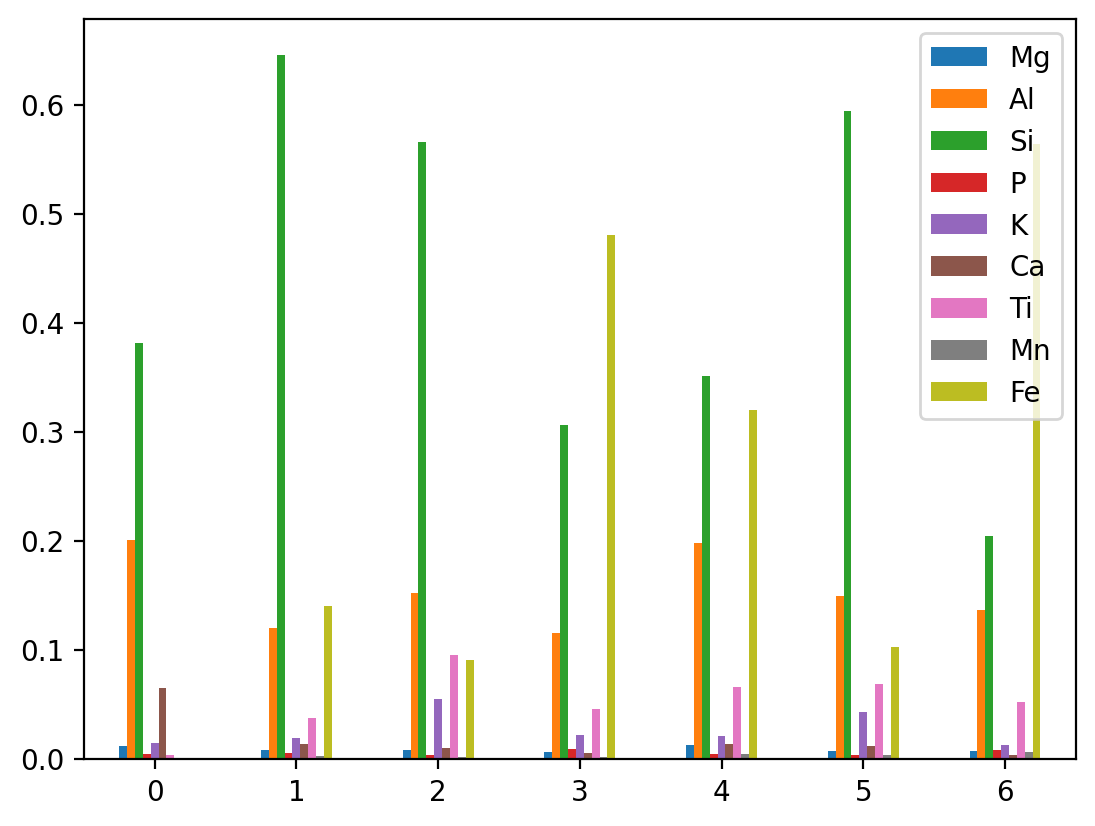

In [107]:
df_bc.iloc[0:7].plot.bar(rot=0)

<Axes: >

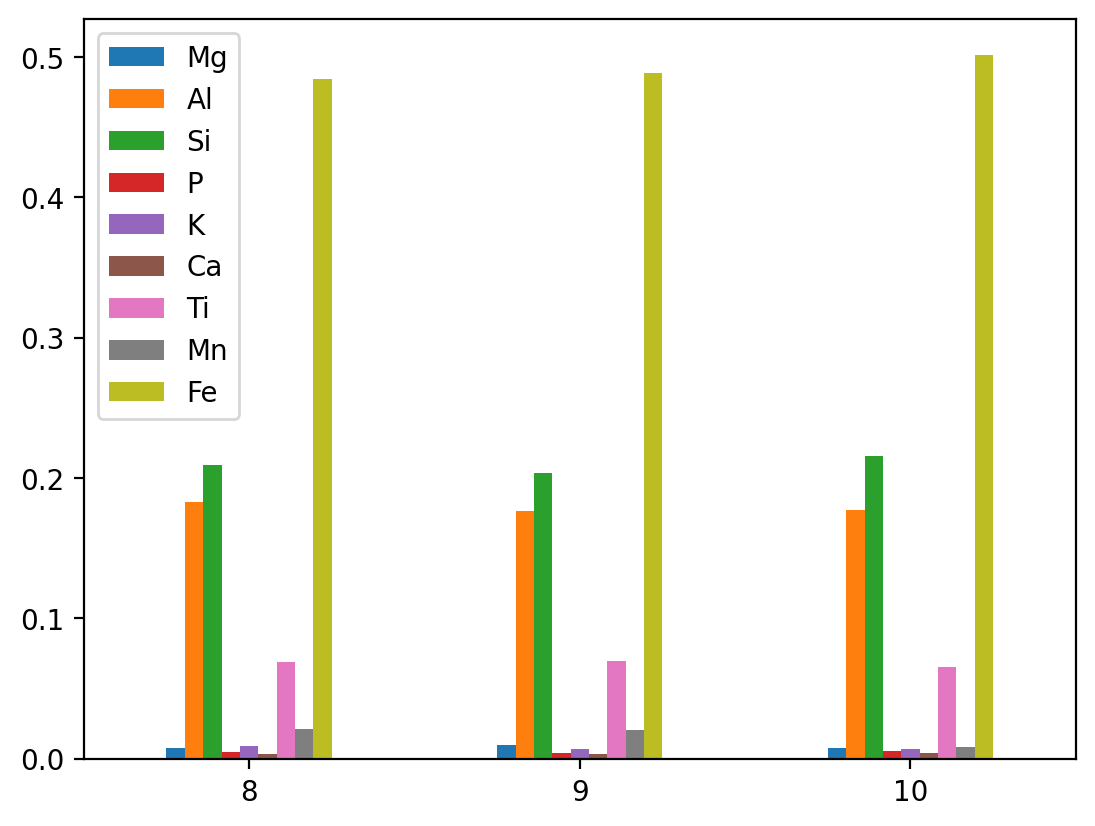

In [108]:
df_bc.iloc[8:11].plot.bar(rot=0)

<Axes: >

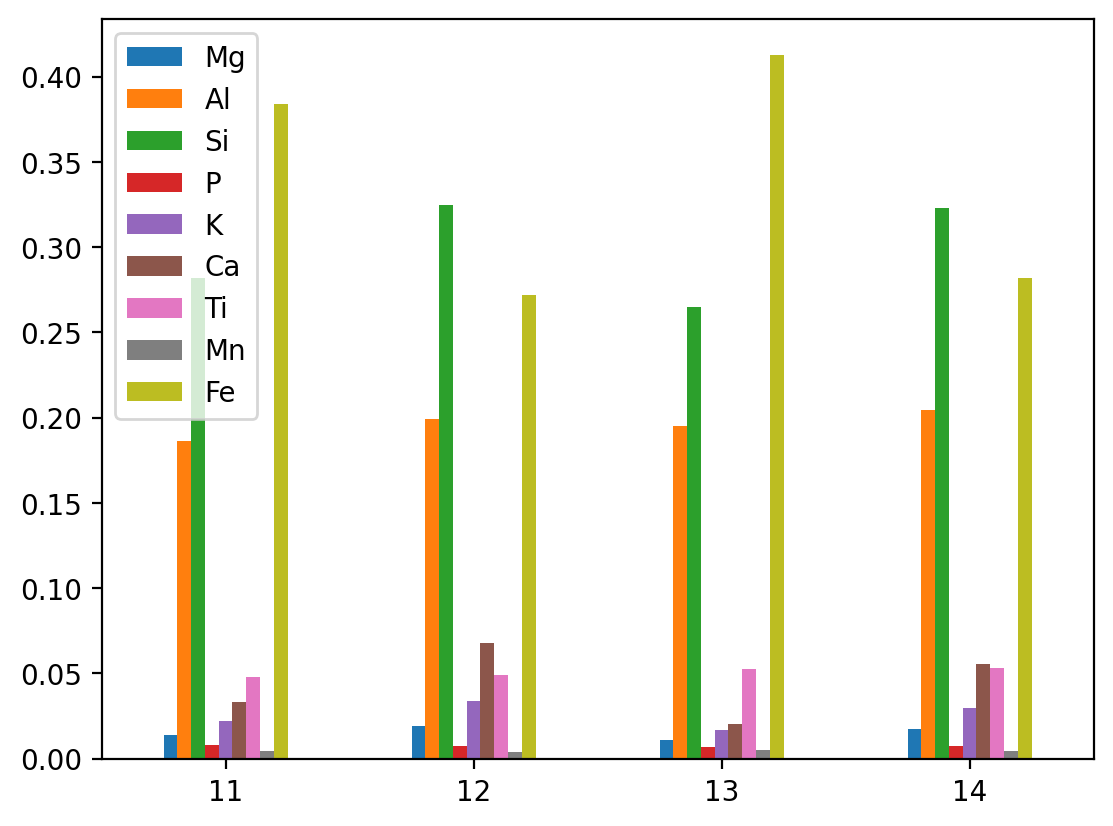

In [109]:
df_bc.iloc[11:15].plot.bar(rot=0)

<Axes: >

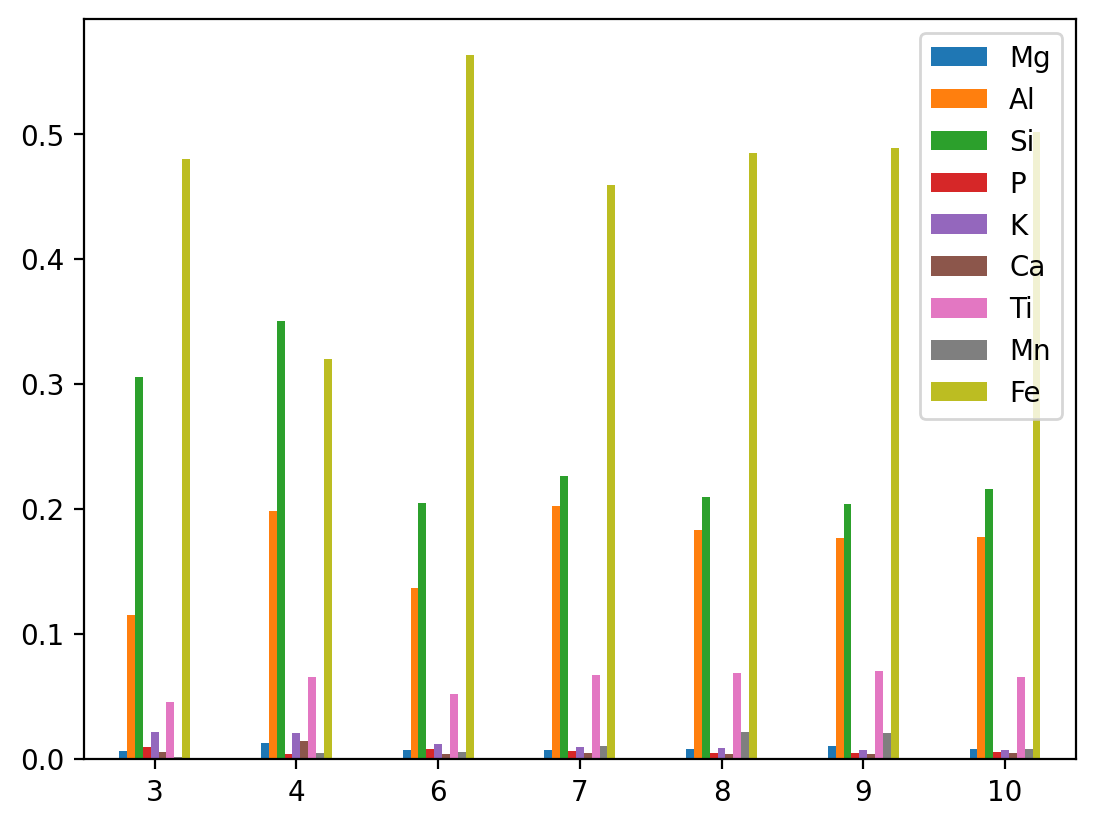

In [110]:
df_bc.iloc[[3,4,6,7,8,9,10]].plot.bar(rot=0)

<Axes: >

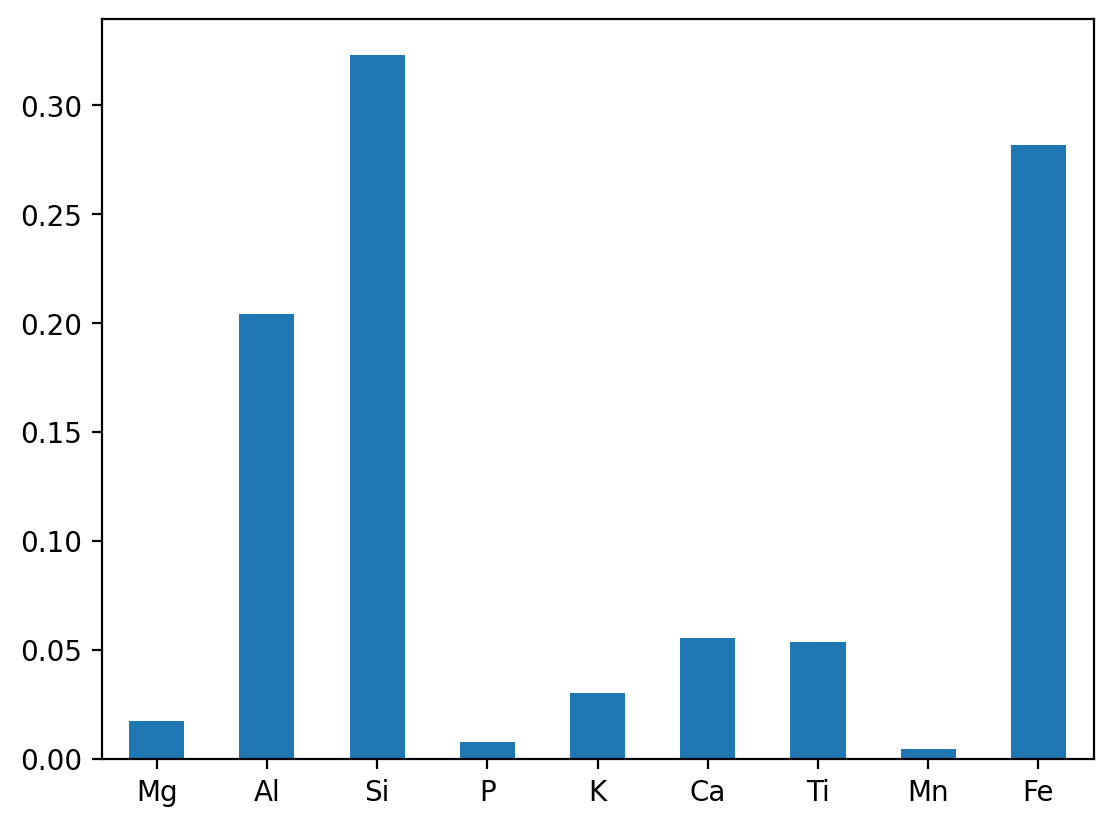

In [111]:
df_bc.iloc[14].plot.bar(rot=0)

In [112]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
data=pd.DataFrame(minmax.fit_transform(df_bc),columns=df_bc.columns)
x = data.fillna(0)
x.head()

Mg        Al        Si         P         K        Ca        Ti  \
0  0.437500  0.960762  0.401447  0.150000  0.151579  0.944099  0.000000   
1  0.093750  0.051570  1.000000  0.283333  0.265263  0.145963  0.370370   
2  0.093750  0.417040  0.818716  0.000000  1.000000  0.099379  1.000000   
3  0.000000  0.000000  0.230787  1.000000  0.309474  0.021739  0.454248   
4  0.476562  0.927130  0.332505  0.116667  0.290526  0.158385  0.673203   

         Mn        Fe  
0  0.000000  0.000000  
1  0.104265  0.247157  
2  0.052133  0.159382  
3  0.047393  0.851990  
4  0.194313  0.567342

<Axes: >

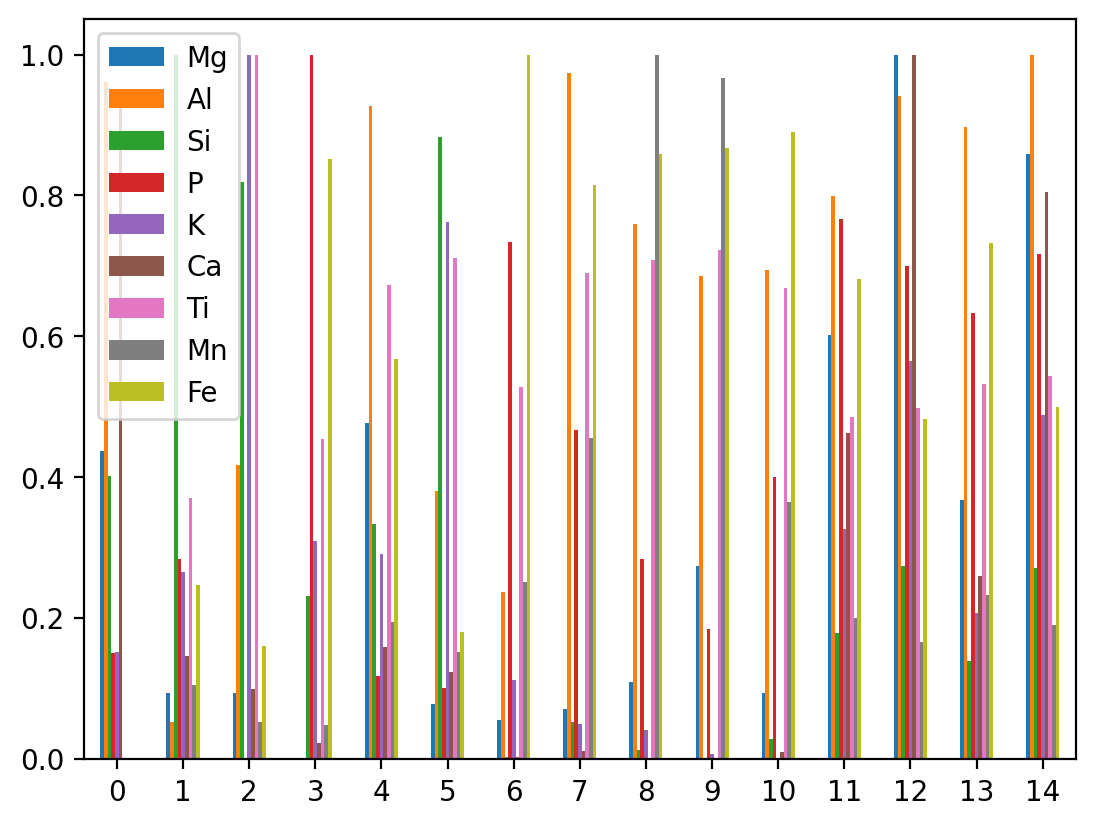

In [113]:
x.plot.bar(rot=0)

In [114]:
#prediction in %
np.round(adb.predict_proba(x),2)*100

array([[25., 34., 41.],
       [28., 37., 34.],
       [25., 34., 41.],
       [41., 34., 25.],
       [37., 28., 34.],
       [25., 34., 41.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.]])

In [115]:
#prediction in %
np.round(rfc.predict_proba(x),2)*100

array([[ 0.,  9., 91.],
       [13., 53., 33.],
       [ 1., 15., 84.],
       [88.,  8.,  4.],
       [24., 36., 40.],
       [ 1., 15., 84.],
       [53., 35., 12.],
       [50., 37., 13.],
       [53., 35., 12.],
       [58., 30., 11.],
       [58., 30., 12.],
       [50., 37., 13.],
       [36., 50., 14.],
       [50., 37., 13.],
       [45., 42., 13.]])

In [116]:
adb.predict(x)

array([3, 2, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [117]:
rfc.predict(x)

array([3, 2, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1])

# Testing the model in the LV core samples

In [118]:
# LOADING THE DATASET
my_sheet = 'S3-LV' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = 'FRX-sondeo-lagunaCopia de 53572_results-MJ.xlsx' # change it to the name of your excel file
df_lv = read_excel(file_name, sheet_name = my_sheet)

In [119]:
df_lv.drop(['Unnamed: 0', 'Cm muestreo' ], axis = 'columns', inplace=True)
#drop the minor elementes
df_lv.drop(['Na', 'S','Cl', 'Sc','V','Cr', 'Ni','Cu', 'Zn','Ga', 'Rb',
         'Sr', 'Y','Zr', 'Nb','Rh', 'Hf','Ta', 'Au','Bi','Ba', 'Co'], axis = 'columns', inplace=True)
df_lv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mg      12 non-null     float64
 1   Al      12 non-null     float64
 2   Si      12 non-null     float64
 3   P       12 non-null     float64
 4   K       12 non-null     float64
 5   Ca      12 non-null     float64
 6   Ti      12 non-null     float64
 7   Mn      12 non-null     float64
 8   Fe      12 non-null     float64
dtypes: float64(9)
memory usage: 996.0 bytes


<Axes: >

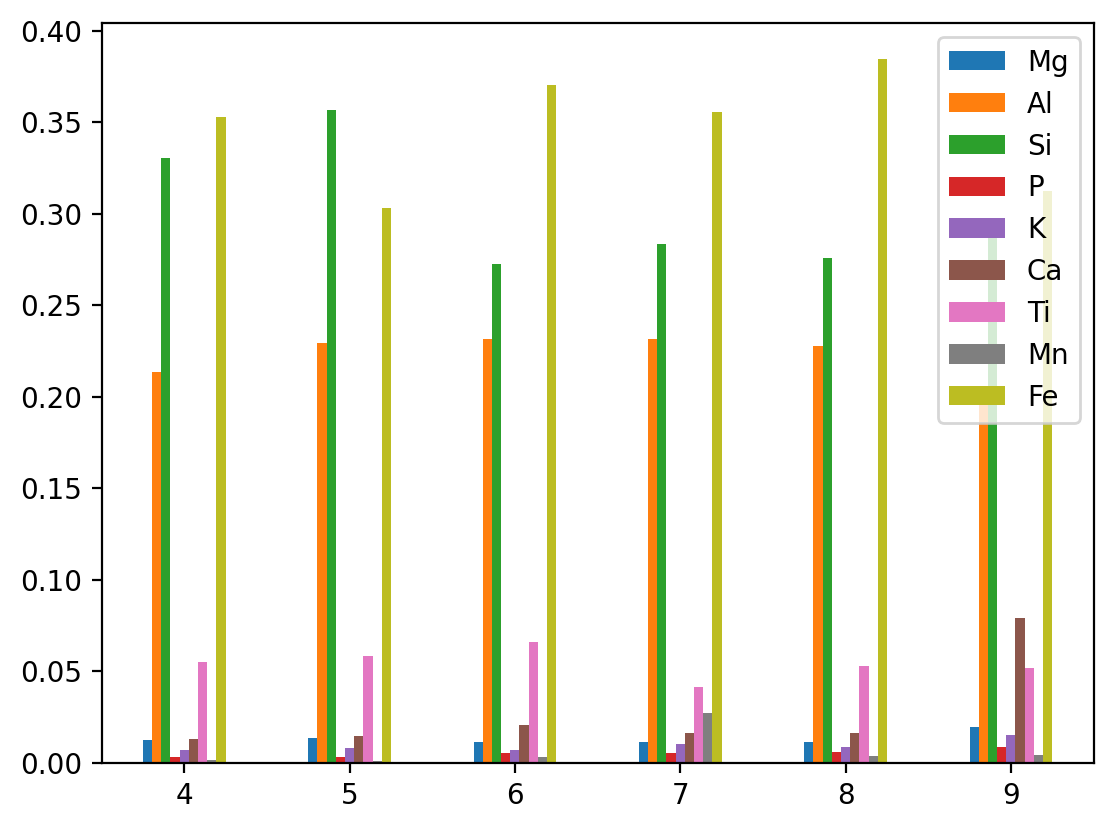

In [120]:
df_lv.iloc[4:10].plot.bar(rot=0)

In [121]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
data=pd.DataFrame(minmax.fit_transform(df_lv),columns=df_lv.columns)
x = data.fillna(0)
x.head()

Mg        Al        Si         P         K        Ca        Ti  \
0  0.482353  0.280620  0.189831  0.275862  0.576471  0.082718  1.000000   
1  0.800000  0.091473  0.744068  0.068966  0.517647  0.110783  0.751799   
2  0.505882  0.000000  0.838136  0.000000  0.223529  0.079764  0.510791   
3  0.400000  0.700775  1.000000  0.051724  0.082353  0.097489  0.575540   
4  0.152941  0.547287  0.529661  0.103448  0.023529  0.022157  0.553957   

         Mn        Fe  
0  0.291188  0.763278  
1  0.091954  0.438543  
2  0.302682  0.459029  
3  0.080460  0.000000  
4  0.003831  0.568285

In [122]:
#prediction in %
np.round(adb.predict_proba(x),2)*100

array([[38., 31., 31.],
       [41., 31., 28.],
       [41., 31., 28.],
       [25., 34., 41.],
       [37., 28., 34.],
       [25., 34., 41.],
       [38., 31., 31.],
       [38., 31., 31.],
       [38., 31., 31.],
       [26., 37., 37.],
       [38., 31., 31.],
       [37., 28., 34.]])

In [123]:
#prediction in %
np.round(rfc.predict_proba(x),2)*100

array([[50., 37., 13.],
       [52., 38., 10.],
       [52., 39., 10.],
       [ 1., 15., 84.],
       [24., 35., 41.],
       [ 1., 11., 89.],
       [58., 30., 13.],
       [34., 49., 16.],
       [50., 37., 13.],
       [ 9., 52., 39.],
       [53., 35., 12.],
       [14., 43., 43.]])

In [124]:
rfc.predict(x)

array([1, 1, 1, 3, 3, 3, 1, 2, 1, 2, 1, 3])

In [125]:
adb.predict(x)

array([1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1])